# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Exploratary Data Analysis](#5.6_Exploratary_Data_Analysis)
  * [5.7 Residual Plots](#5.7_Residual_Plots)
  * [5.8 Feature Selection and GridSearch](#5.8_Feature_Selection_and_GridSearch)
  * [5.9 Model Scenarios](#5.9_Model_Scenarios)
    * [5.9.1 Scenario 1(With All Features)](#5.9.1_Scenario_1(With_All_Features))
      * [5.9.1.1 K-Fold Cross Validation](#5.9.1.1_K-Fold_Cross_Validation)
      * [5.9.1.2 Polynomial Transformation](#5.9.1.2_Polynomial_Transformation)
      * [5.9.1.3 Model Prediction](#5.9.1.3_Model_Prediction)
    * [5.9.2 Scenario 2(Without All Features)](#5.9.2_Scenario_2(Without_All_Features))
      * [5.9.2.1 K-Fold Cross Validation](#5.9.2.1_K-Fold_Cross_Validation)
      * [5.9.2.2 Polynomial Transformation](#5.9.2.2_Polynomial_Transformation)
      * [5.9.2.3 Model Prediction](#5.9.2.3_Model_Prediction)
  * [5.10 Model Comparison](#5.10_Model_Comparison)
  * [5.10 Variance Score](#5.10_Variance_Score)  
  * [5.11 Conclusion](#5.11_Conclusion)

## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for airbnb price and leverage it to gain some insights into what price might actually support as well as explore the sensitivity of changes to various id parameters. Note that this relies on the implicit assumption that all other ids are largely setting prices. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what area ideal price could/should be, and how that might change under various scenarios.

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sb 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from sklearn import preprocessing
from scipy.stats import norm
from scipy import stats
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

#!pip install scikit-learn
#Import ML models:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score

import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [2]:
expected_model_version = '1.0'
model_path = 'file.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [3]:
airbnb_data_cleaned_v22 = pd.read_csv('airbnb_data_cleaned_v22.csv')
scaled_airbnb_data_cleaned_v2 = pd.read_csv('scaled_airbnb_data_cleaned_v2.csv')
neighbourhood_summary_v2 = pd.read_csv('neighbourhood_summary_v2.csv')

In [4]:
scaled_airbnb_data_cleaned_v2.head()

,Unnamed: 0,latitude,longitude,bedrooms,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,home_Loft,home_Place,home_Rental,home_Serviced,home_Tent,home_Tiny,home_Townhouse,home_Vacation,home_Villa,home_casa
0,0,39.760390,-104.92968,1.0,35.0,2,3.00,2.50,2.50,3.00,...,0,0,0,0,0,0,0,0,0,0
1,1,39.727850,-104.93783,3.0,149.0,0,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2,39.758520,-104.98846,4.0,190.0,68,4.78,4.88,4.62,4.78,...,0,0,0,0,0,0,1,0,0,0
3,3,39.736019,-105.05072,2.0,87.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
4,4,39.771430,-105.02028,2.0,300.0,12,5.00,5.00,5.00,5.00,...,0,0,0,0,0,0,0,0,0,0


In [5]:
scaled_airbnb_data_cleaned_v2.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
scaled_airbnb_data_cleaned_v2.shape

(4889, 70)

In [7]:
scaled_airbnb_data_cleaned_v2.describe()

,latitude,longitude,bedrooms,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,home_Loft,home_Place,home_Rental,home_Serviced,home_Tent,home_Tiny,home_Townhouse,home_Vacation,home_Villa,home_casa
count,4889.000000,4889.000000,4826.000000,4889.000000,4889.000000,4169.000000,4169.000000,4169.000000,4169.000000,4169.000000,...,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000,4889.000000
mean,39.742019,-104.976967,2.219229,207.300675,60.000205,4.844042,4.864114,4.829959,4.897448,4.898789,...,0.016568,0.001227,0.202086,0.002864,0.000205,0.001636,0.094293,0.000614,0.000409,0.000409
std,0.031392,0.059799,1.577698,1253.739351,106.678936,0.343043,0.320743,0.356735,0.308302,0.323413,...,0.127658,0.035014,0.401597,0.053441,0.014302,0.040423,0.292266,0.024766,0.020224,0.020224
min,39.625750,-105.095964,1.000000,17.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.727300,-105.017140,1.000000,85.000000,2.000000,4.830000,4.860000,4.800000,4.910000,4.910000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.748200,-104.984930,2.000000,120.000000,16.000000,4.930000,4.950000,4.930000,4.970000,4.980000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39.762460,-104.960030,3.000000,185.000000,70.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39.847417,-104.673817,18.000000,42770.000000,1478.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
airbnb_data_cleaned_v22.head()

,Unnamed: 0,neighbourhood_cleansed,id,description,host_id,latitude,longitude,room_type,bathrooms,bedrooms,...,reviews_per_month,home_type,neighborhood_cleansed_id_number,neighborhood_cleansed_price,denver_neighborhoods_population,region_area_sq_miles,id_review_scores_rating_ac_region_ratio,id_review_scores_location_ac_region_ratio,id_bedrooms_count_ac_mean_region_ratio,id_number_of_reviews_ac_region_ratio
0,0,North Park Hill,6.070000e+17,Home in Denver · 1 bedroom · 1 bed · 1 shared ...,430149575,39.760390,-104.92968,Private room,1 shared bath,1.0,...,0.11,Home,73.0,158.577465,9382.0,1.52,0.616353,0.819121,0.376289,0.000303
1,1,Hale,5.460000e+17,Rental unit in Denver · 2 bedrooms · 3 beds · ...,169214047,39.727850,-104.93783,Entire home/apt,2 baths,3.0,...,NaN,Rental,63.0,116.065574,6936.0,0.73,NaN,NaN,1.657895,0.000000
2,2,Five Points,5.242953e+07,Townhouse in Denver · ★4.78 · 3 bedrooms · 4 b...,107279139,39.758520,-104.98846,Entire home/apt,2.5 baths,4.0,...,2.52,Townhouse,415.0,174.136585,12712.0,0.96,0.984566,1.028110,1.649899,0.001940
3,3,West Colfax,6.320000e+17,Townhouse in Denver · ★New · 2 bedrooms · 2 be...,416194740,39.736019,-105.05072,Entire home/apt,2.5 baths,2.0,...,NaN,Townhouse,226.0,196.633028,9740.0,1.22,NaN,NaN,0.786713,0.000000
4,4,Sunnyside,6.880000e+17,Home in Denver · ★5.0 · 2 bedrooms · 2 beds · ...,133612752,39.771430,-105.02028,Entire home/apt,1 bath,2.0,...,0.99,Home,144.0,189.361702,9726.0,1.32,1.018330,1.004938,0.773842,0.001195


In [9]:
airbnb_data_cleaned_v22.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
airbnb_data_cleaned_v22.shape

(4889, 29)

In [11]:
neighbourhood_summary_v2.head()

,Unnamed: 0.1,Unnamed: 0,neighbourhood_cleansed,neighborhood_cleansed_id_number,neighborhood_cleansed_review_scores_rating,neighborhood_cleansed_review_scores_location,neighborhood_cleansed_bedrooms,neighborhood_cleansed_number_of_reviews,neighborhood_cleansed_price,denver_neighborhoods_population,region_area_sq_miles
0,0,0,Athmar Park,55,4.832766,4.713191,2.444444,1952,142.472727,8898,1.53
1,1,1,Auraria,4,4.996667,4.996667,1.750000,90,163.750000,705,0.32
2,2,2,Baker,118,4.815963,4.846330,1.846154,6018,122.119658,4879,1.26
3,3,3,Barnum,34,4.769259,4.658148,2.176471,1043,121.264706,6111,1.47
4,4,4,Barnum West,26,4.834545,4.713182,2.115385,1330,115.230769,5376,0.74


In [12]:
neighbourhood_summary_v2.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [13]:
neighbourhood_summary_v2.head()

,neighbourhood_cleansed,neighborhood_cleansed_id_number,neighborhood_cleansed_review_scores_rating,neighborhood_cleansed_review_scores_location,neighborhood_cleansed_bedrooms,neighborhood_cleansed_number_of_reviews,neighborhood_cleansed_price,denver_neighborhoods_population,region_area_sq_miles
0,Athmar Park,55,4.832766,4.713191,2.444444,1952,142.472727,8898,1.53
1,Auraria,4,4.996667,4.996667,1.750000,90,163.750000,705,0.32
2,Baker,118,4.815963,4.846330,1.846154,6018,122.119658,4879,1.26
3,Barnum,34,4.769259,4.658148,2.176471,1043,121.264706,6111,1.47
4,Barnum West,26,4.834545,4.713182,2.115385,1330,115.230769,5376,0.74


## 5.6 Solve Some problems in the dataset<a id='5.6_Solve_Some_problems_in_the_dataset'></a>

In [14]:
airbnb_data_cleaned_v3 = airbnb_data_cleaned_v22

In [15]:
airbnb_data_cleaned_v3.head()

,neighbourhood_cleansed,id,description,host_id,latitude,longitude,room_type,bathrooms,bedrooms,price,...,reviews_per_month,home_type,neighborhood_cleansed_id_number,neighborhood_cleansed_price,denver_neighborhoods_population,region_area_sq_miles,id_review_scores_rating_ac_region_ratio,id_review_scores_location_ac_region_ratio,id_bedrooms_count_ac_mean_region_ratio,id_number_of_reviews_ac_region_ratio
0,North Park Hill,6.070000e+17,Home in Denver · 1 bedroom · 1 bed · 1 shared ...,430149575,39.760390,-104.92968,Private room,1 shared bath,1.0,35.0,...,0.11,Home,73.0,158.577465,9382.0,1.52,0.616353,0.819121,0.376289,0.000303
1,Hale,5.460000e+17,Rental unit in Denver · 2 bedrooms · 3 beds · ...,169214047,39.727850,-104.93783,Entire home/apt,2 baths,3.0,149.0,...,NaN,Rental,63.0,116.065574,6936.0,0.73,NaN,NaN,1.657895,0.000000
2,Five Points,5.242953e+07,Townhouse in Denver · ★4.78 · 3 bedrooms · 4 b...,107279139,39.758520,-104.98846,Entire home/apt,2.5 baths,4.0,190.0,...,2.52,Townhouse,415.0,174.136585,12712.0,0.96,0.984566,1.028110,1.649899,0.001940
3,West Colfax,6.320000e+17,Townhouse in Denver · ★New · 2 bedrooms · 2 be...,416194740,39.736019,-105.05072,Entire home/apt,2.5 baths,2.0,87.0,...,NaN,Townhouse,226.0,196.633028,9740.0,1.22,NaN,NaN,0.786713,0.000000
4,Sunnyside,6.880000e+17,Home in Denver · ★5.0 · 2 bedrooms · 2 beds · ...,133612752,39.771430,-105.02028,Entire home/apt,1 bath,2.0,300.0,...,0.99,Home,144.0,189.361702,9726.0,1.32,1.018330,1.004938,0.773842,0.001195


In [16]:
airbnb_data_cleaned_v3.columns

Index(['neighbourhood_cleansed', 'id', 'description', 'host_id', 'latitude',
       'longitude', 'room_type', 'bathrooms', 'bedrooms', 'price',
       'number_of_reviews', 'last_scraped', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'home_type', 'neighborhood_cleansed_id_number',
       'neighborhood_cleansed_price', 'denver_neighborhoods_population',
       'region_area_sq_miles', 'id_review_scores_rating_ac_region_ratio',
       'id_review_scores_location_ac_region_ratio',
       'id_bedrooms_count_ac_mean_region_ratio',
       'id_number_of_reviews_ac_region_ratio'],
      dtype='object')

In [17]:
airbnb_data_cleaned_v3 = airbnb_data_cleaned_v3[['id', 'host_id', 'neighbourhood_cleansed', 'description', 'latitude'
            , 'longitude', 'room_type', 'price', 'last_scraped', 'number_of_reviews', 'reviews_per_month'
            ]]

In [18]:
airbnb_data_cleaned_v3.head()

,id,host_id,neighbourhood_cleansed,description,latitude,longitude,room_type,price,last_scraped,number_of_reviews,reviews_per_month
0,6.070000e+17,430149575,North Park Hill,Home in Denver · 1 bedroom · 1 bed · 1 shared ...,39.760390,-104.92968,Private room,35.0,2023-12-29,2,0.11
1,5.460000e+17,169214047,Hale,Rental unit in Denver · 2 bedrooms · 3 beds · ...,39.727850,-104.93783,Entire home/apt,149.0,2023-12-29,0,NaN
2,5.242953e+07,107279139,Five Points,Townhouse in Denver · ★4.78 · 3 bedrooms · 4 b...,39.758520,-104.98846,Entire home/apt,190.0,2023-12-29,68,2.52
3,6.320000e+17,416194740,West Colfax,Townhouse in Denver · ★New · 2 bedrooms · 2 be...,39.736019,-105.05072,Entire home/apt,87.0,2023-12-29,0,NaN
4,6.880000e+17,133612752,Sunnyside,Home in Denver · ★5.0 · 2 bedrooms · 2 beds · ...,39.771430,-105.02028,Entire home/apt,300.0,2023-12-29,12,0.99


In [19]:
airbnb_data_cleaned_v3.isnull().sum()

id                          0
host_id                     0
neighbourhood_cleansed      0
description                 0
latitude                    0
longitude                   0
room_type                   0
price                       0
last_scraped                0
number_of_reviews           0
reviews_per_month         721
dtype: int64

## 5.6 Exploratary Data Analysis<a id='5.6_Exploratary_Data_Analysis'></a>

Below graph shows details about price and room type

Text(0.5, 1.0, 'Room Type vs Price')

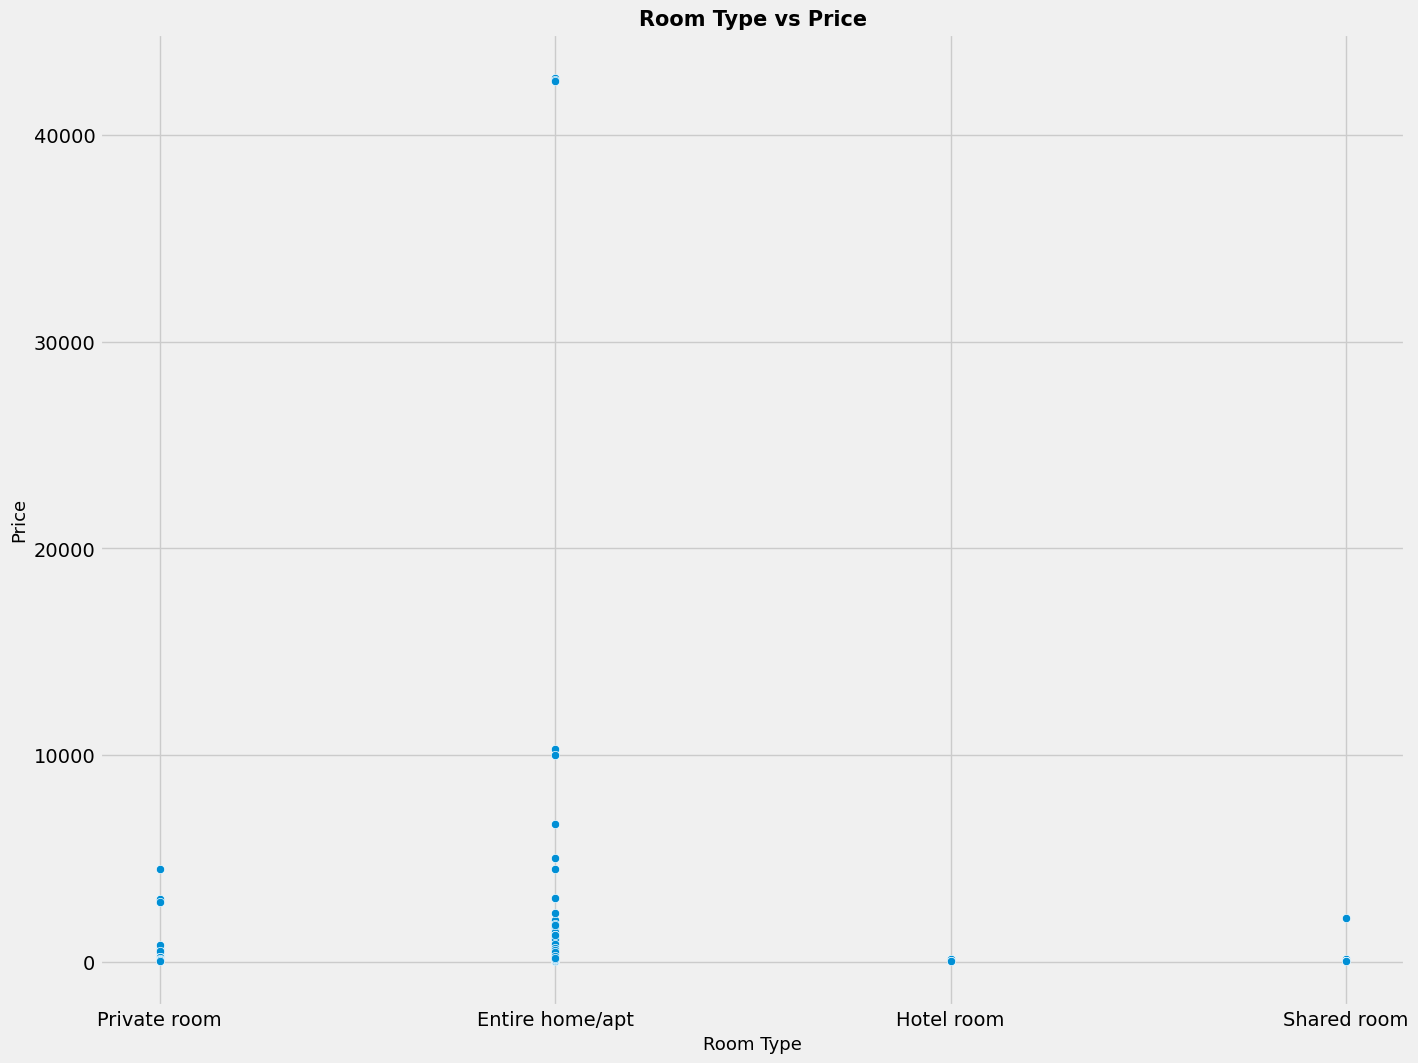

In [20]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='room_type', y='price', data=airbnb_data_cleaned_v3)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price",size=15, weight='bold')

Below graph shows details about price and room type based on neighbourhood_cleansed

Text(0.5, 1.0, 'Room Type vs Price vs neighbourhood_cleansed')

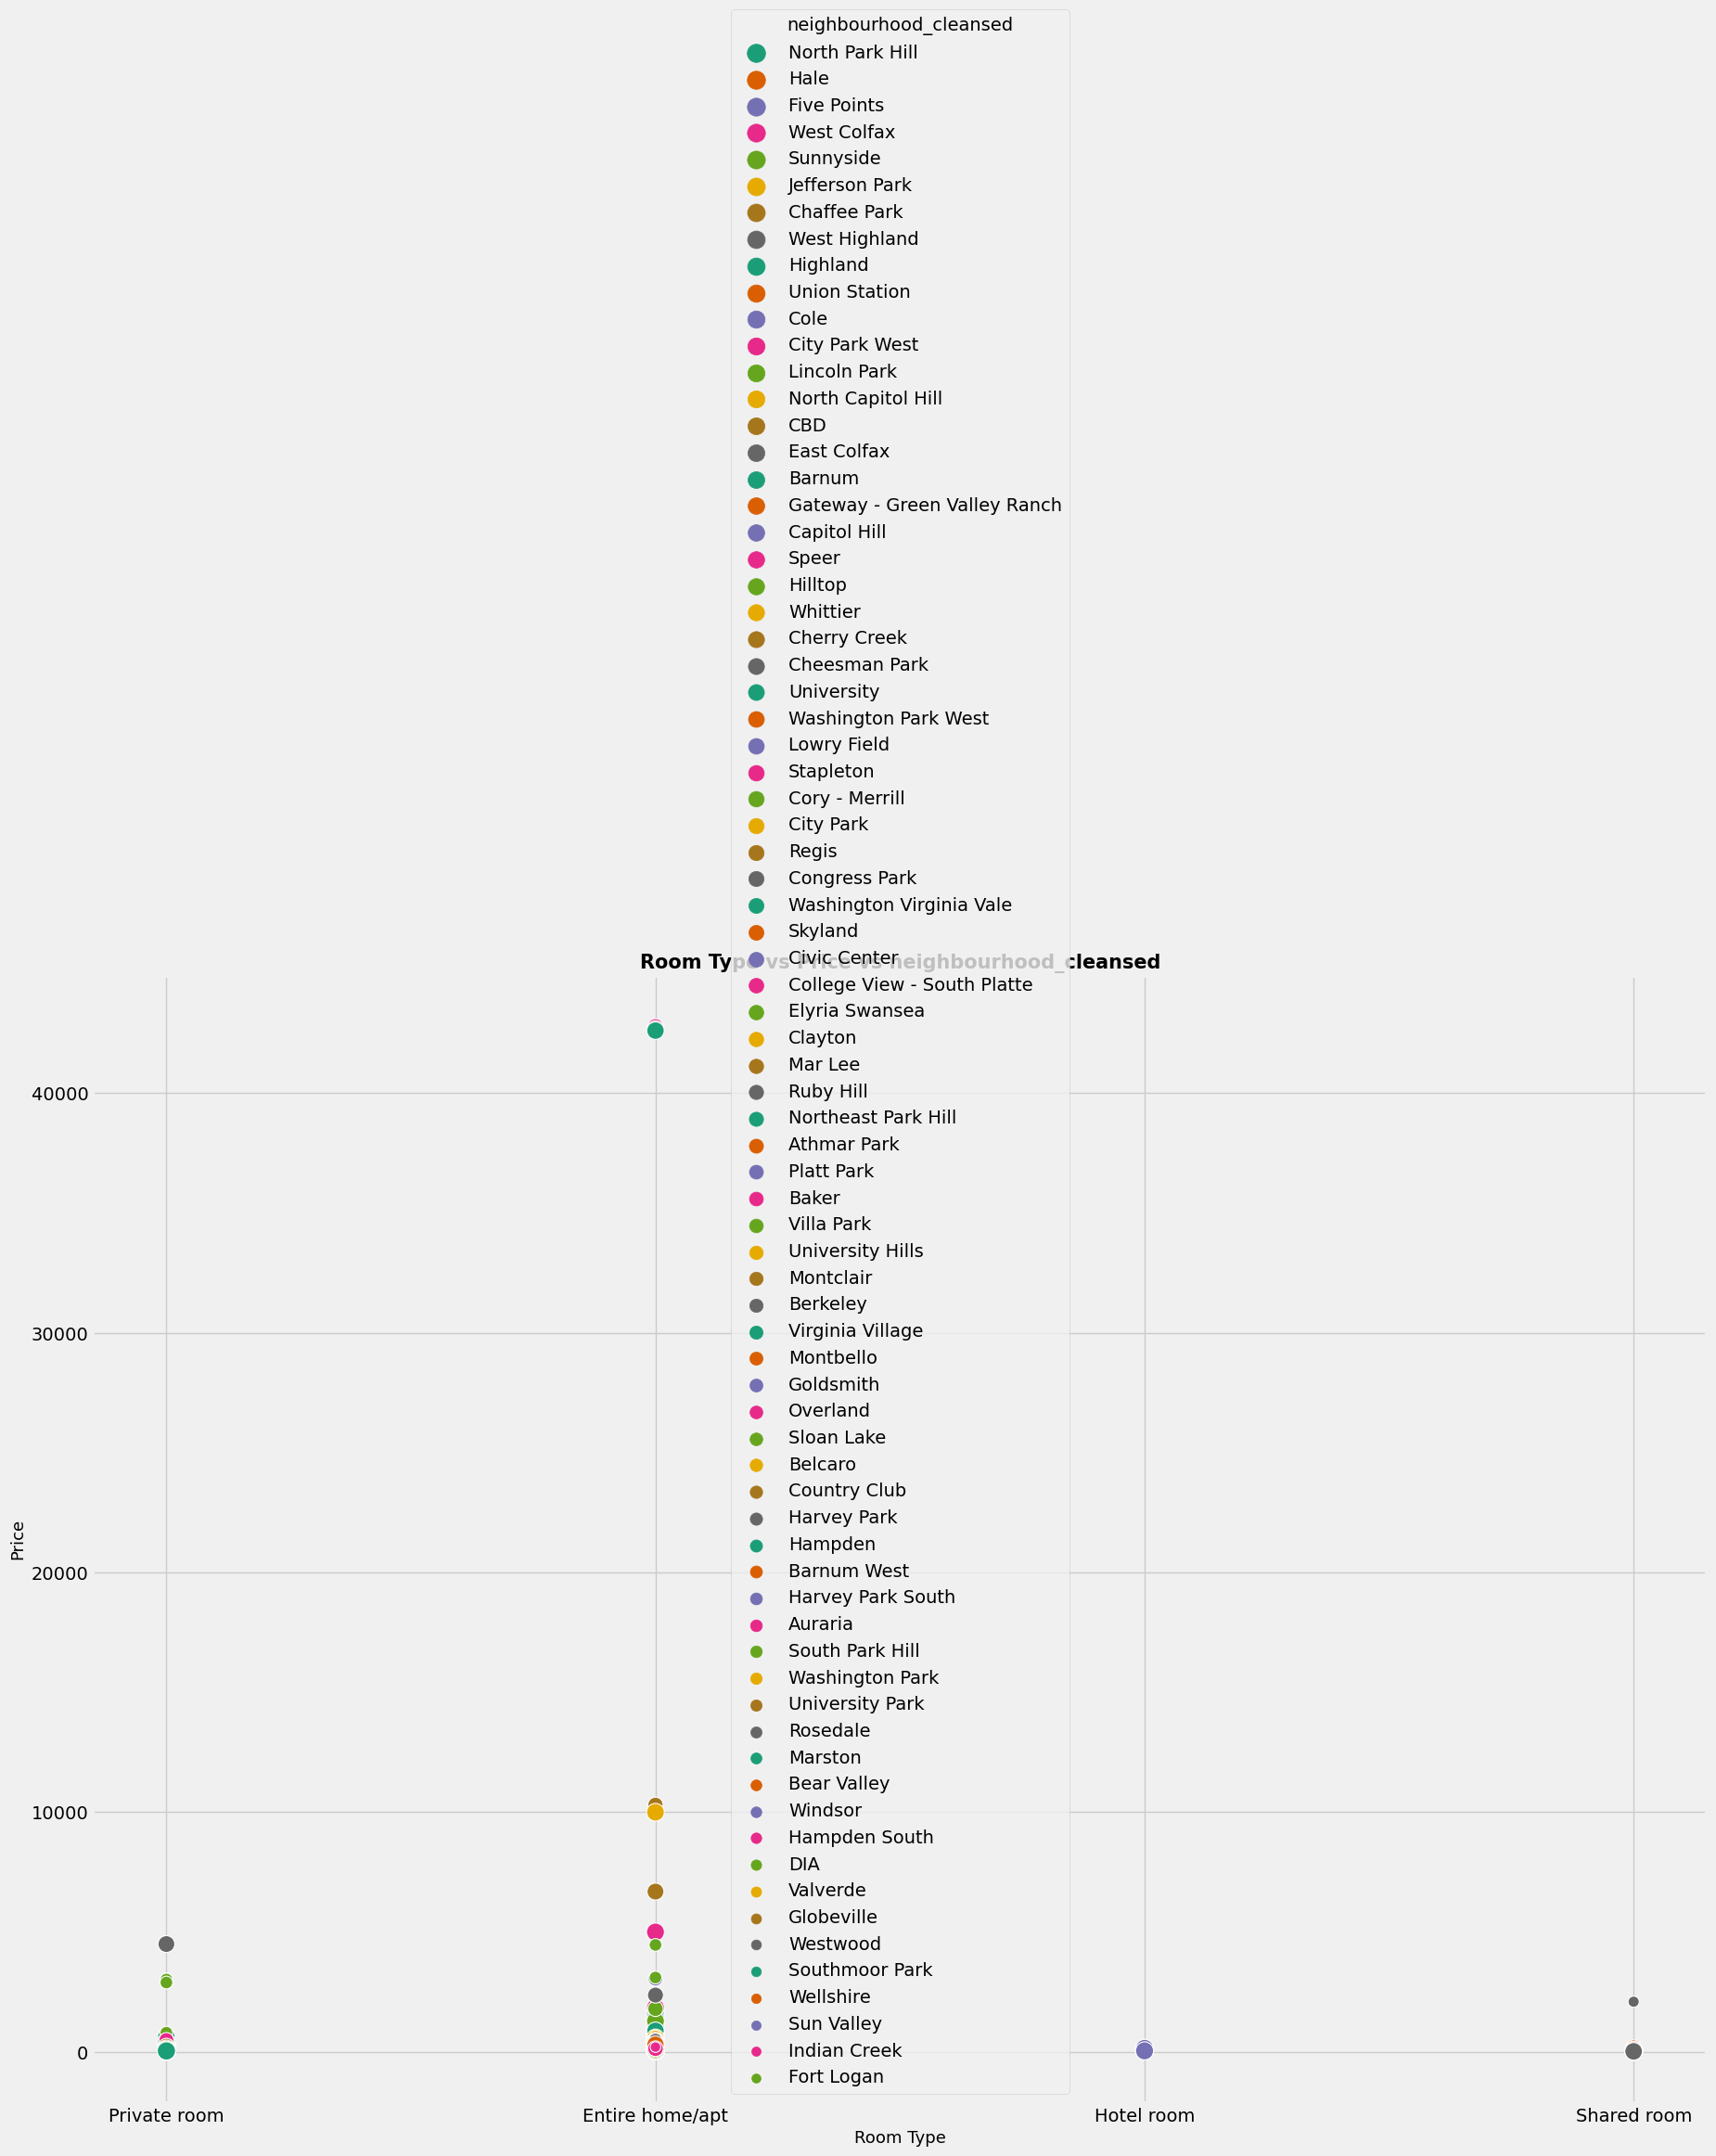

In [21]:
plt.figure(figsize=(20,15))
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_cleansed", size="neighbourhood_cleansed",
            sizes=(50, 200), palette="Dark2", data=airbnb_data_cleaned_v3)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price vs neighbourhood_cleansed",size=15, weight='bold')

Another graph is about price vs number of reviews based on neighborhood group. It shows us the lowest prices have higher reviews than the higher prices. It shows negative correlation between price and number of reviews. Also North Park Hill, Hale, Five Points, West Colfax, and Sunnyside areas have higher reviews than others.

Text(0.5, 1.0, 'Price vs Number of Reviews vs Neighbourhood Cleansed')

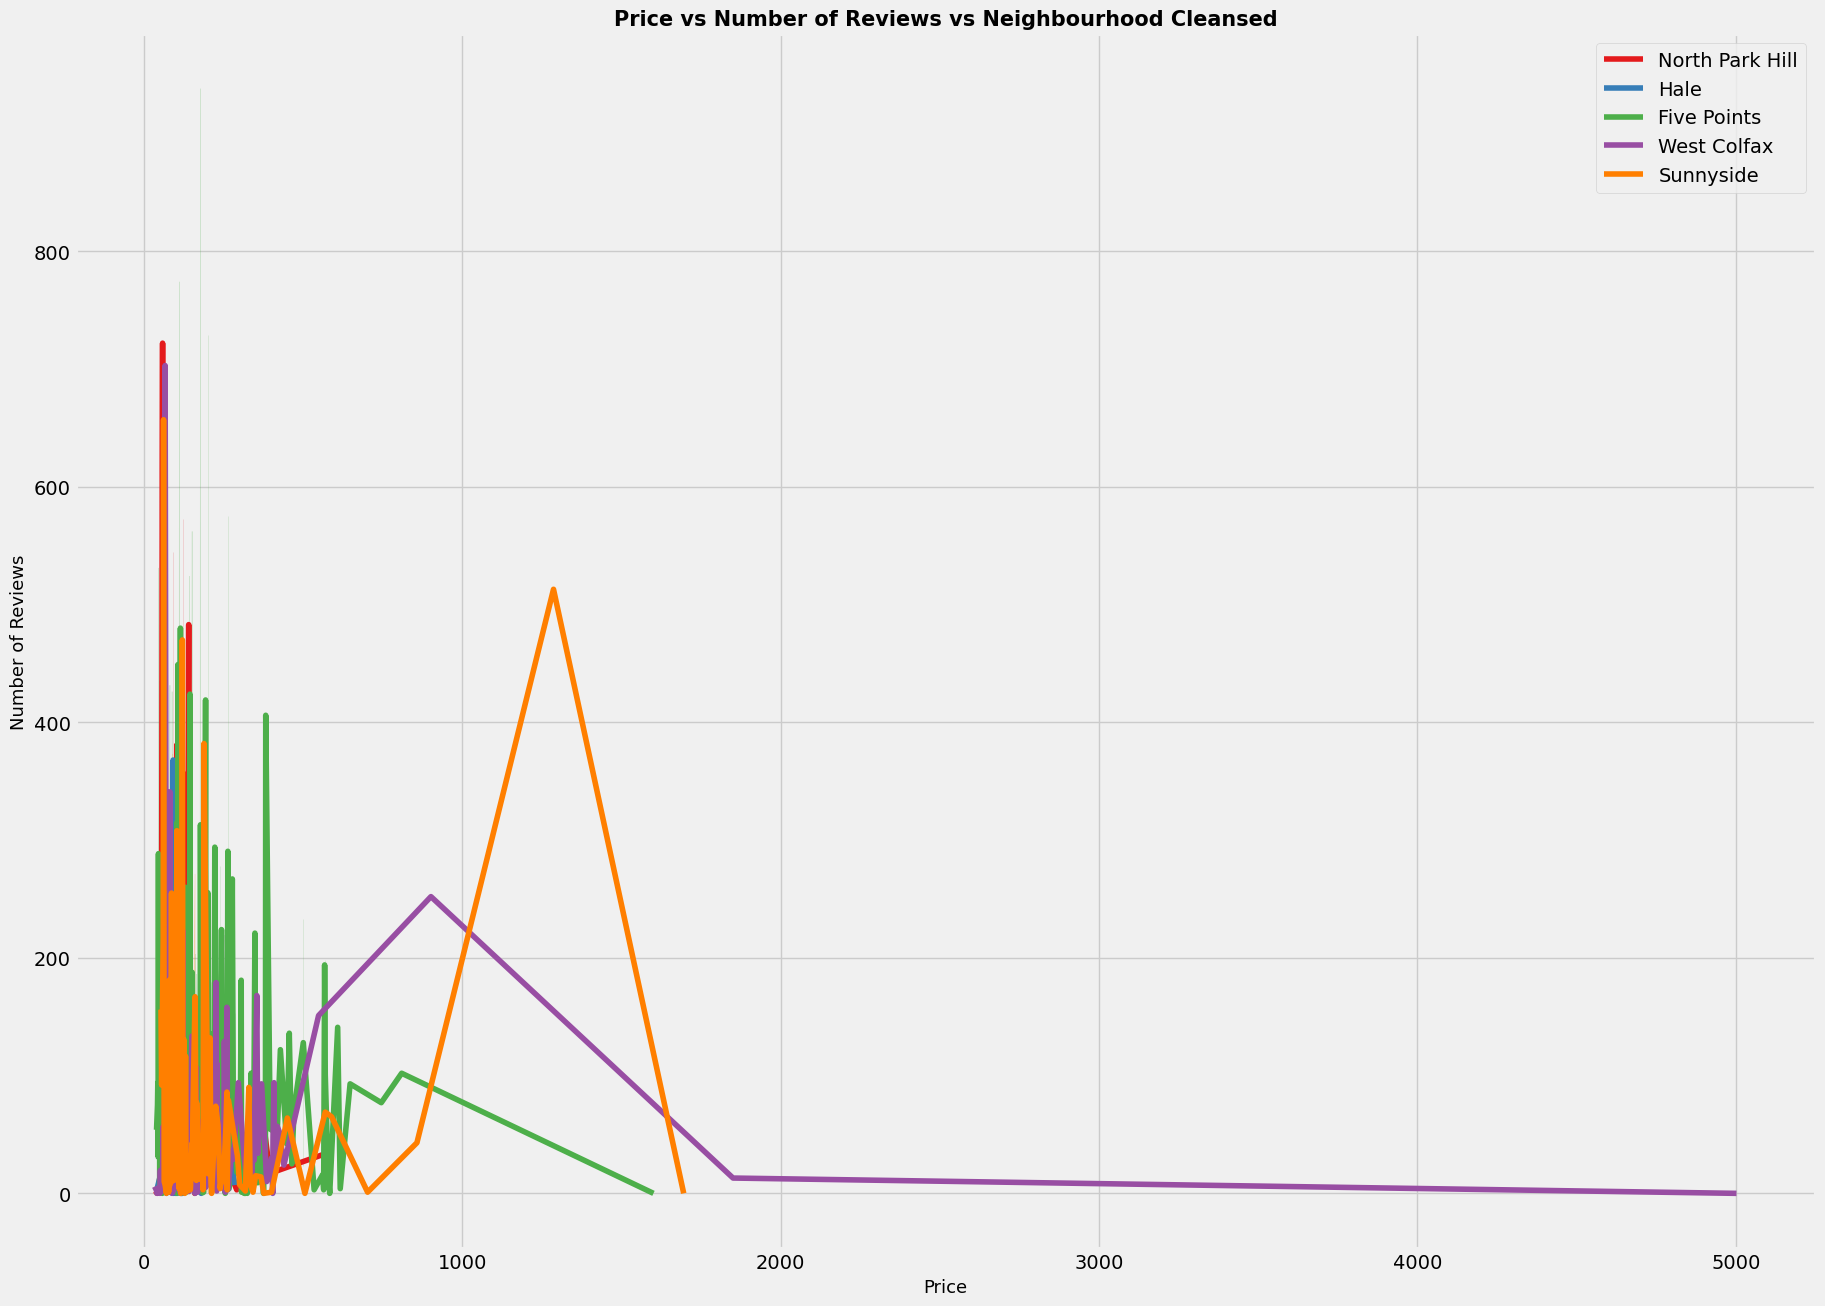

In [22]:
plt.figure(figsize=(20,15))
sns.set_palette("Set1")

sns.lineplot(x='price', y='number_of_reviews', 
             data=airbnb_data_cleaned_v3[airbnb_data_cleaned_v3['neighbourhood_cleansed']=='North Park Hill'],
             label='North Park Hill')
sns.lineplot(x='price', y='number_of_reviews', 
             data=airbnb_data_cleaned_v3[airbnb_data_cleaned_v3['neighbourhood_cleansed']=='Hale'],
             label='Hale')
sns.lineplot(x='price', y='number_of_reviews', 
             data=airbnb_data_cleaned_v3[airbnb_data_cleaned_v3['neighbourhood_cleansed']=='Five Points'],
             label='Five Points')
sns.lineplot(x='price', y='number_of_reviews', 
             data=airbnb_data_cleaned_v3[airbnb_data_cleaned_v3['neighbourhood_cleansed']=='West Colfax'],
             label='West Colfax')
sns.lineplot(x='price', y='number_of_reviews', 
             data=airbnb_data_cleaned_v3[airbnb_data_cleaned_v3['neighbourhood_cleansed']=='Sunnyside'],
             label='Sunnyside')
plt.xlabel("Price", size=13)
plt.ylabel("Number of Reviews", size=13)
plt.title("Price vs Number of Reviews vs Neighbourhood Cleansed",size=15, weight='bold')

In [23]:
airbnb_data_cleaned_v3['neighbourhood_cleansed']= airbnb_data_cleaned_v3['neighbourhood_cleansed'].astype("category").cat.codes
airbnb_data_cleaned_v3['room_type'] = airbnb_data_cleaned_v3['room_type'].astype("category").cat.codes
airbnb_data_cleaned_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4889 entries, 0 to 4888
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      4889 non-null   float64
 1   host_id                 4889 non-null   int64  
 2   neighbourhood_cleansed  4889 non-null   int8   
 3   description             4889 non-null   object 
 4   latitude                4889 non-null   float64
 5   longitude               4889 non-null   float64
 6   room_type               4889 non-null   int8   
 7   price                   4889 non-null   float64
 8   last_scraped            4889 non-null   object 
 9   number_of_reviews       4889 non-null   int64  
 10  reviews_per_month       4168 non-null   float64
dtypes: float64(5), int64(2), int8(2), object(2)
memory usage: 353.4+ KB


Text(0.5, 1.0, 'Price Distribution Plot')

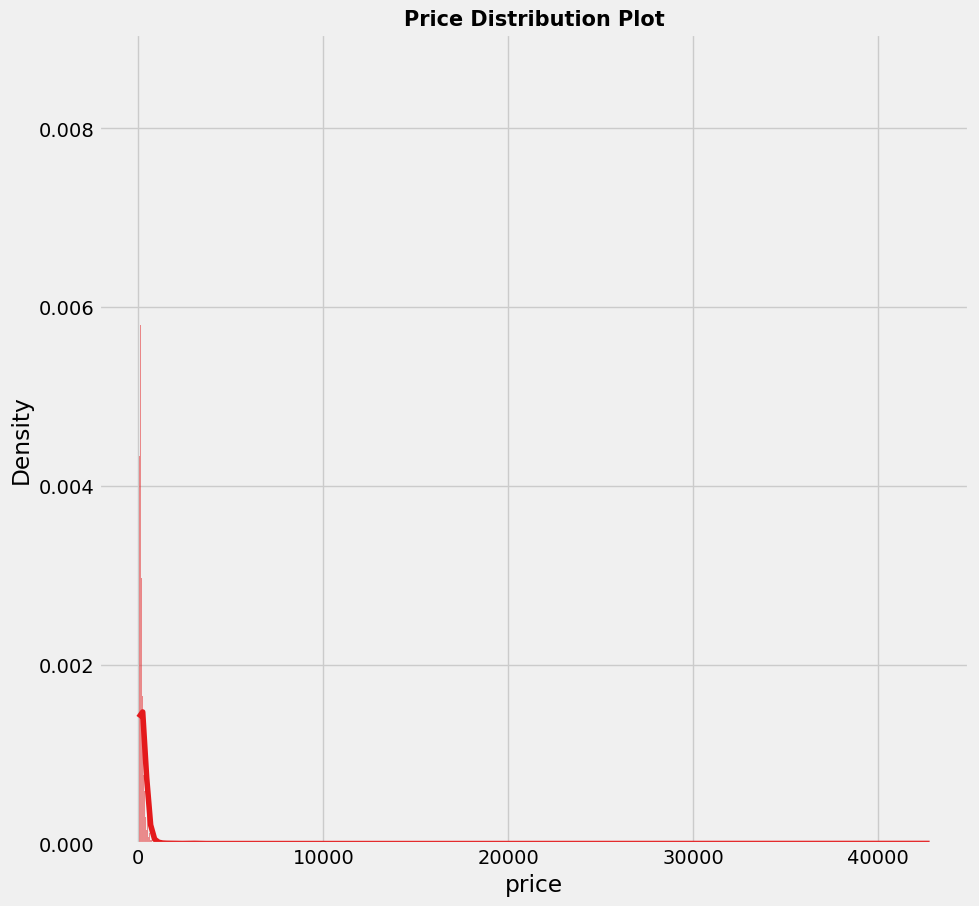

In [24]:
plt.figure(figsize=(10,10))
sns.histplot(airbnb_data_cleaned_v3['price'],  kde=True, stat="density")
plt.title("Price Distribution Plot",size=15, weight='bold')

The above distribution graph shows that there is a right-skewed distribution on price. This means there is a positive skewness. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis

Since division by zero is a problem, log+1 transformation would be better.

In [25]:
airbnb_data_cleaned_v3['price_log'] = np.log(airbnb_data_cleaned_v3.price+1)

Text(0.5, 1.0, 'Log-Price Distribution Plot')

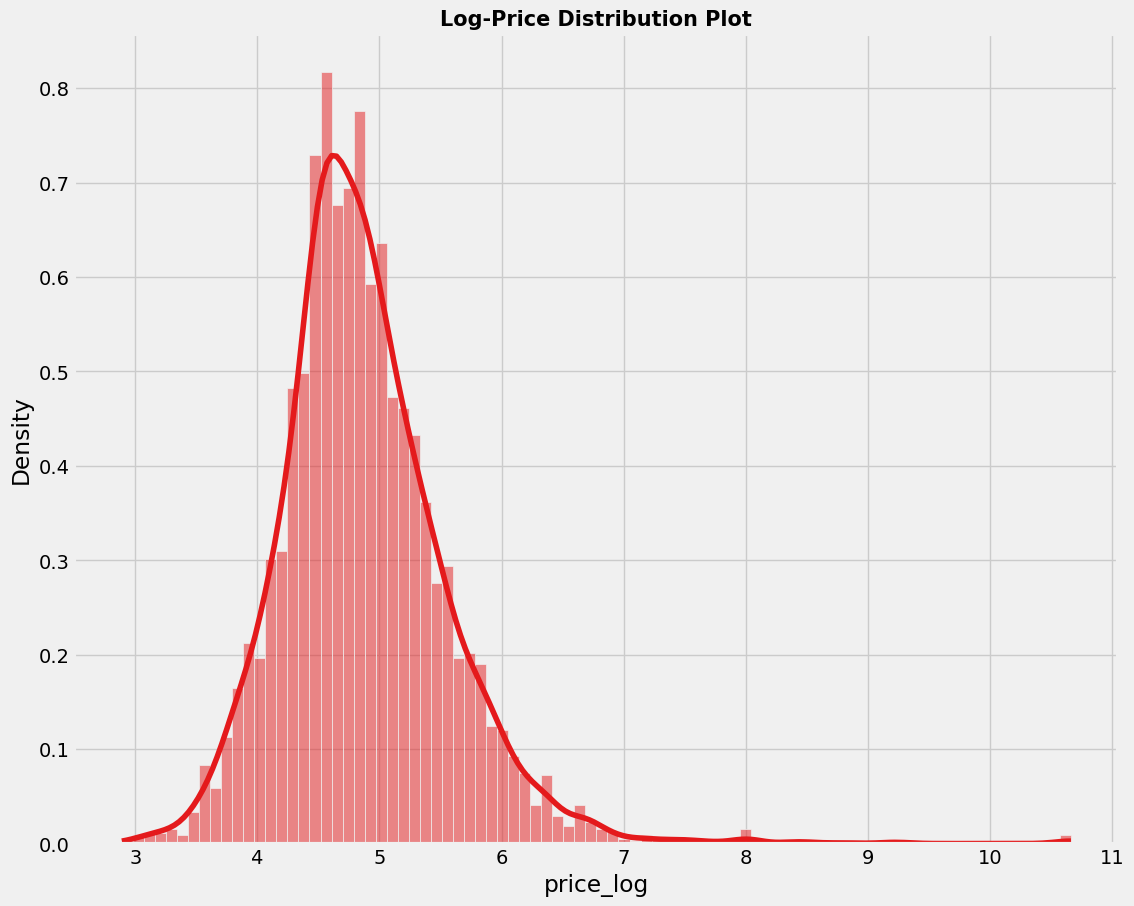

In [26]:
plt.figure(figsize=(12,10))
sns.histplot(airbnb_data_cleaned_v3['price_log'], kde=True, stat="density")
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

In below graph, the good fit indicates that normality is a reasonable approximation.

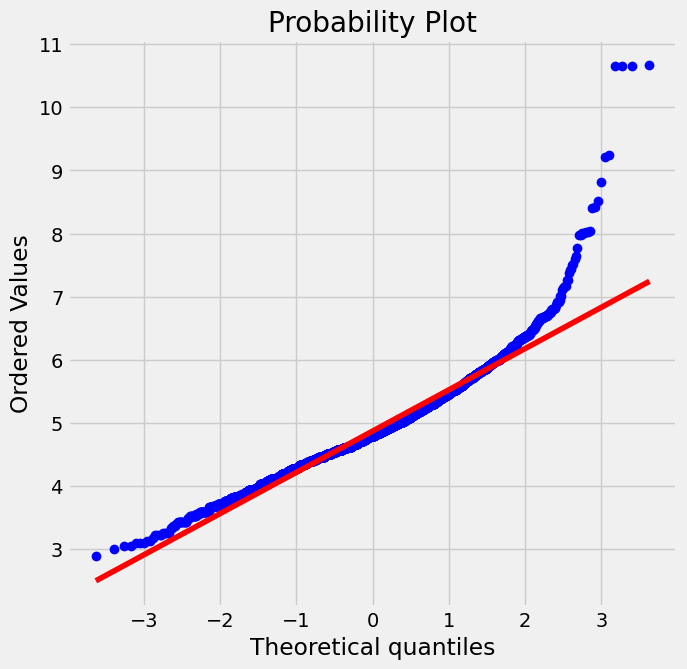

In [27]:
plt.figure(figsize=(7,7))
stats.probplot(airbnb_data_cleaned_v3['price_log'], plot=plt)
plt.show()

In [28]:
airbnb_data_cleaned_v3.columns

Index(['id', 'host_id', 'neighbourhood_cleansed', 'description', 'latitude',
       'longitude', 'room_type', 'price', 'last_scraped', 'number_of_reviews',
       'reviews_per_month', 'price_log'],
      dtype='object')

In [29]:
den_model = airbnb_data_cleaned_v3.drop(columns=['description','id' ,'host_id','last_scraped','price'])
den_model.isnull().sum()

neighbourhood_cleansed      0
latitude                    0
longitude                   0
room_type                   0
number_of_reviews           0
reviews_per_month         721
price_log                   0
dtype: int64

Number of reviews feature has some missing data. For this feature, missing data will be replaced with mean. Since the data is more symmetric, mean replacement would be better.

In [30]:
mean = airbnb_data_cleaned_v3['reviews_per_month'].mean()
den_model['reviews_per_month'].fillna(mean, inplace=True)
den_model.isnull().sum()

neighbourhood_cleansed    0
latitude                  0
longitude                 0
room_type                 0
number_of_reviews         0
reviews_per_month         0
price_log                 0
dtype: int64

Now it is time to make more details about data. A correlation table will be created and the Pearson method will be used.

Text(0.5, 1.0, 'Correlation Matrix')

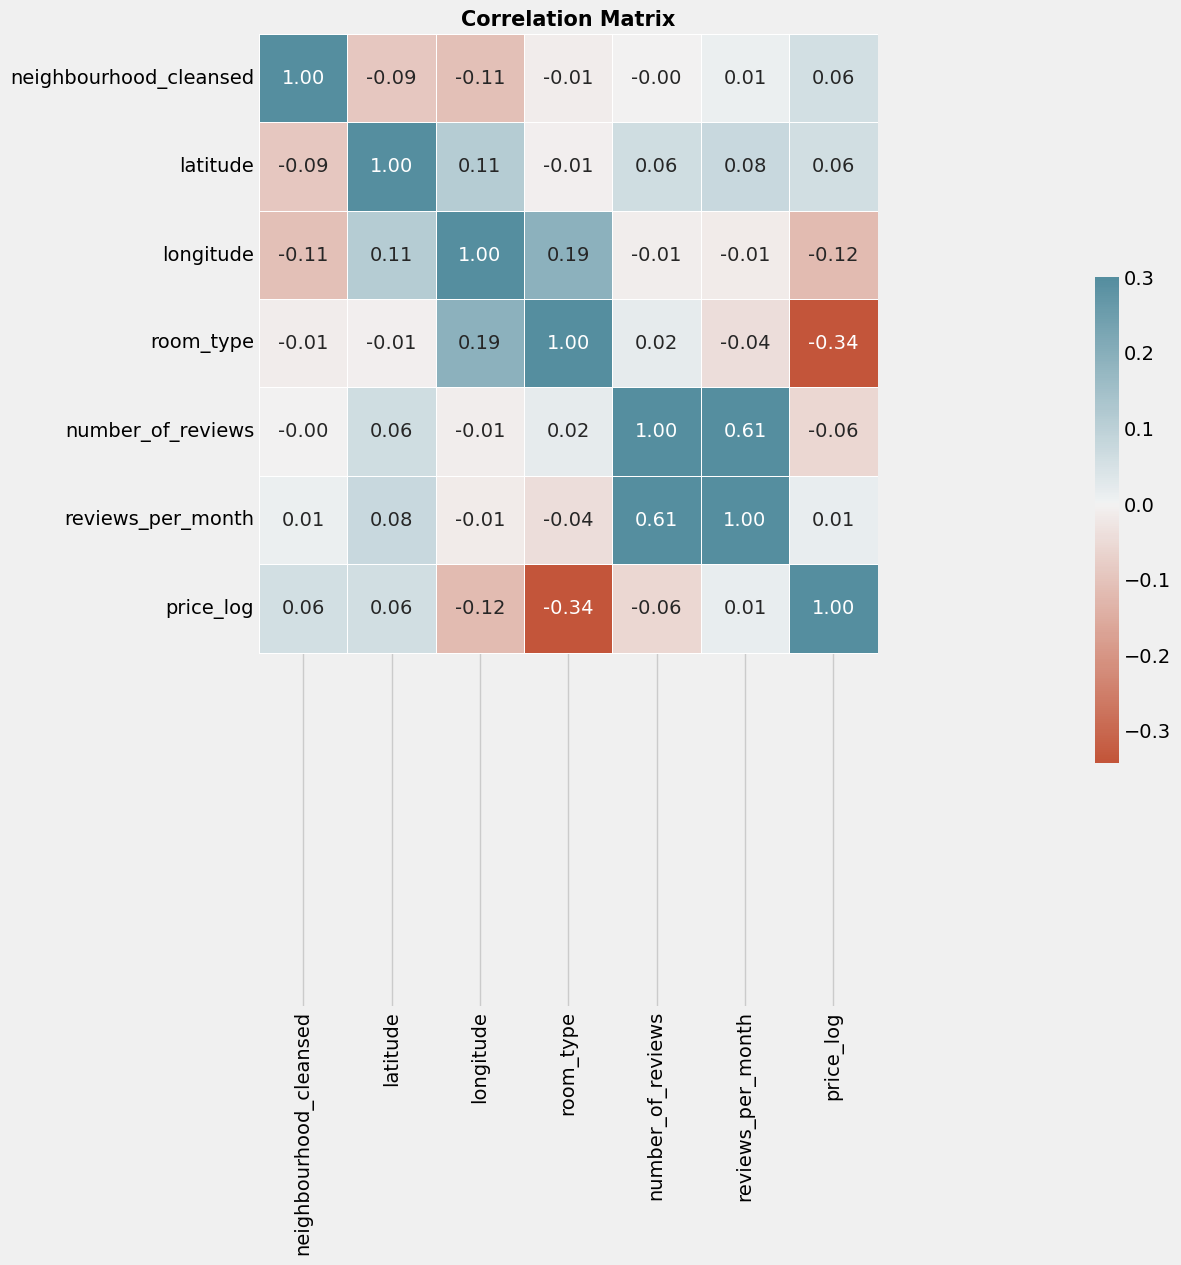

In [31]:
plt.figure(figsize=(50,12))
palette = sns.diverging_palette(20, 220, n=256)
corr=den_model.corr(method='pearson', numeric_only = True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

The correlation table shows that there is no strong relationship between price and other features. This indicates no feature needed to be taken out of data. This relationship will be detailed with Residual Plots and Multicollinearity.

## 5.7 Residual Plots<a id='5.7_Residual_Plots'></a>

Residual Plot is strong method to detect outliers, non-linear data and detecting data for regression models. The below charts show the residual plots for each feature with the ``price``. 

An ideal Residual Plot, the red line would be horizontal. Based on the below charts, most features are non-linear. On the other hand, there are not many outliers in each feature. This result led to underfitting. Underfitting can occur when input features do not have a strong relationship to target variables or over-regularized. For avoiding underfitting new data features can be added or regularization weight could be reduced.

In this kernel, since the input feature data could not be increased, Regularized Linear Models will be used for regularization and polynomial transformation will be made to avoid underfitting. 

In [32]:
den_model_x, den_model_y = den_model.iloc[:,:-1], den_model.iloc[:,-1]

In [33]:
den_model_x

,neighbourhood_cleansed,latitude,longitude,room_type,number_of_reviews,reviews_per_month
0,46,39.760390,-104.92968,2,2,0.110000
1,30,39.727850,-104.93783,0,0,2.051171
2,25,39.758520,-104.98846,0,68,2.520000
3,72,39.736019,-105.05072,0,0,2.051171
4,60,39.771430,-105.02028,0,12,0.990000
...,...,...,...,...,...,...
4884,60,39.774110,-105.01761,0,5,0.400000
4885,61,39.752110,-104.99469,0,0,2.051171
4886,61,39.752320,-105.00347,0,0,2.051171
4887,58,39.803850,-104.87780,0,3,1.050000


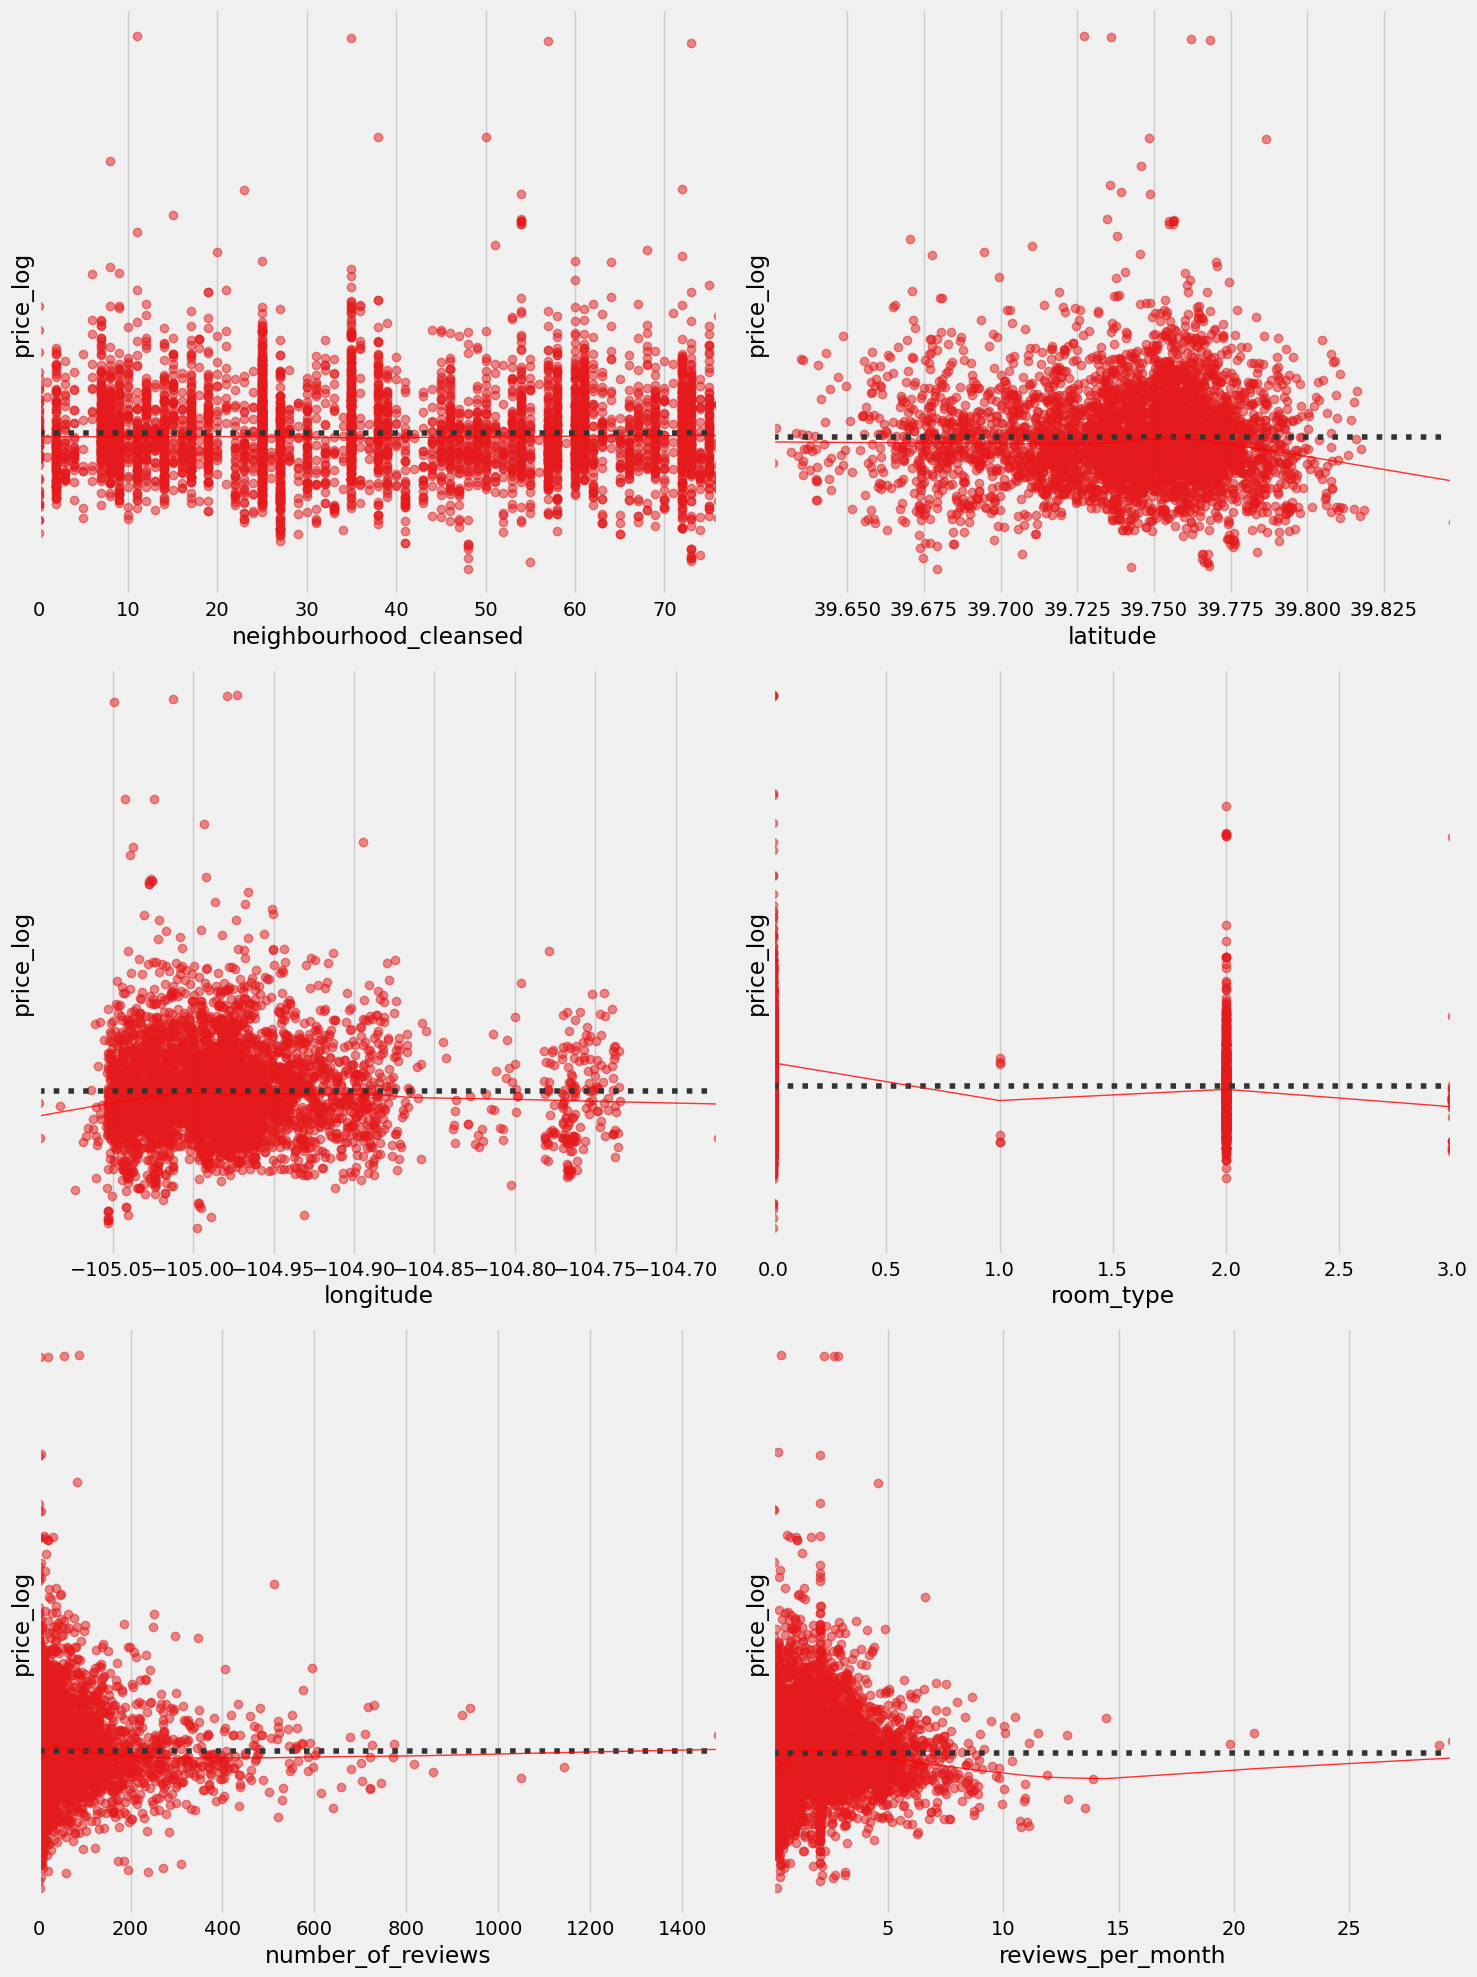

In [34]:
f, axes = plt.subplots(3, 2, figsize=(15, 20))
sns.residplot(x=den_model_x.iloc[:,0],y=den_model_y, data=airbnb_data_cleaned_v3, lowess=True, ax=axes[0, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(x=den_model_x.iloc[:,1],y=den_model_y, data=airbnb_data_cleaned_v3, lowess=True, ax=axes[0, 1],
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(x=den_model_x.iloc[:,2],y=den_model_y, data=airbnb_data_cleaned_v3, lowess=True, ax=axes[1, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(x=den_model_x.iloc[:,3],y=den_model_y, data=airbnb_data_cleaned_v3, lowess=True, ax=axes[1, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(x=den_model_x.iloc[:,4],y=den_model_y, data=airbnb_data_cleaned_v3, lowess=True, ax=axes[2, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
sns.residplot(x=den_model_x.iloc[:,5],y=den_model_y, data=airbnb_data_cleaned_v3, lowess=True, ax=axes[2, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.setp(axes, yticks=[])
plt.tight_layout()

## 5.8 Feature Selection and GridSearch<a id='5.8_Feature_Selection_and_GridSearch'></a>

First, ``Standard Scaler`` technique will be used to normalize the data set. Thus, each feature has 0 mean and 1 standard deviation. 

In [35]:
scaler = StandardScaler()
den_model_x = scaler.fit_transform(den_model_x)

Secondly, data will be split in a 70–30 ratio

In [36]:
X_train, X_test, y_train, y_test = train_test_split(den_model_x, den_model_y, test_size=0.3,random_state=42)

Now it is time to build a ``feature importance`` graph. For this ``Extra Trees Classifier`` method will be used. In the below code, ``lowess=True`` makes sure the lowest regression line is drawn.

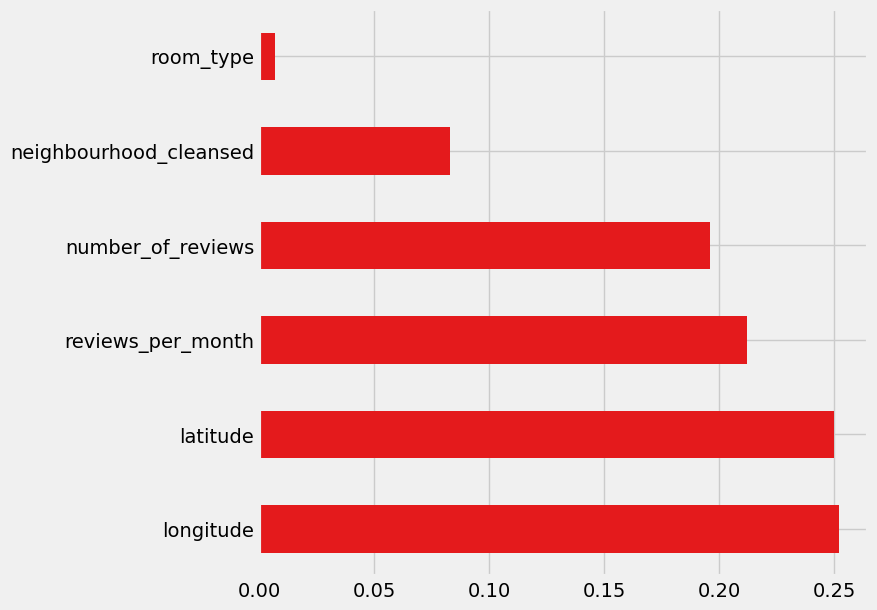

In [37]:
lab_enc = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train,lab_enc.fit_transform(y_train))

plt.figure(figsize=(7,7))
feat_importances = pd.Series(feature_model.feature_importances_, index=den_model.iloc[:,:-1].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The above graph shows the feature importance of dataset. According to that, ``neighborhood cleansed`` and ``room type`` have the lowest importance on the model. Under this result, the model building will be made in 2 phases. In the first phase, models will be built within all features and in the second phase, models will be built without ``neighborhood cleansed`` and ``room type`` features.  

## 5.9 Model Scenarios<a id='5.9_Model_Scenarios'></a>

### 5.9.1 Scenario 1(With All Features)<a id='5.9.1_Scenario_1(With_All_Features)'></a>

Correlation matrix, Residual Plots and Multicollinearity results show that underfitting occurs on the model and there is no multicollinearity on the independent variables. Avoiding underfitting will be made with ``Polynomial Transformation`` since no new features can not be added or replaced with the existing ones.  

In model building section, `Linear Regression`, `Ridge Regression`, and `Lasso Regression` models will be built. These models will be used to avoiding plain ``Linear Regression`` and show the results with a little of regularization. 

First, `GridSearchCV` algorithm will be used to find the best parameters and tuning hyperparameters for each model. In this algorithm ``5-Fold Cross Validation`` and ``Mean Squared Error Regression Loss`` metrics will be used. 

In [38]:
### Linear Regression ###

def linear_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_LR= LinearRegression()

    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_LR = GridSearchCV(estimator=model_LR,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_LR.fit(input_x, input_y)
    best_parameters_LR = grid_search_LR.best_params_  
    best_score_LR = grid_search_LR.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)


# linear_reg(den_model_x, den_model_y)

In [39]:
### Ridge Regression ###

def ridge_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Ridge= Ridge()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_Ridge = GridSearchCV(estimator=model_Ridge,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_Ridge.fit(input_x, input_y)
    best_parameters_Ridge = grid_search_Ridge.best_params_  
    best_score_Ridge = grid_search_Ridge.best_score_ 
    print(best_parameters_Ridge)
    print(best_score_Ridge)
    
# ridge_reg(den_model_x, den_model_y)

In [40]:
### Lasso Regression ###

def lasso_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Lasso= Lasso()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
                         param_grid=(dict(alpha=alphas, normalize= normalizes)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_lasso.fit(input_x, input_y)
    best_parameters_lasso = grid_search_lasso.best_params_  
    best_score_lasso = grid_search_lasso.best_score_ 
    print(best_parameters_lasso)
    print(best_score_lasso)

# lasso_reg(den_model_x, den_model_y)

In [41]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_RF = RandomForestRegressor()

    # prepare a range of hyperparameters to test
    params = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.
    grid_search_rf = GridSearchCV(estimator=model_RF,  
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.
    grid_search_rf.fit(input_x, input_y)
    best_parameters_rf = grid_search_rf.best_params_  
    best_score_rf = grid_search_rf.best_score_ 
    print(best_parameters_rf)
    print(best_score_rf)

# random_forest_reg(input_x, input_y)

#### 5.9.1.1 K-Fold Cross Validation<a id='5.9.1.1_K-Fold_Cross_Validation'></a>

Before model building, 5-Fold Cross Validation will be implemented for validation.

In [42]:
kfold_cv=KFold(n_splits=5, shuffle=False)
for train_index, test_index in kfold_cv.split(den_model_x,den_model_y):
    X_train, X_test = den_model_x[train_index], den_model_x[test_index]
    y_train, y_test = den_model_y[train_index], den_model_y[test_index]

#### 5.9.1.2 Polynomial Transformation<a id='5.9.1.2_Polynomial_Transformation'></a>

The polynomial transformation will be made with a second degree which adding the square of each feature.

In [43]:
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train = Poly.fit_transform(X_train)
X_test = Poly.fit_transform(X_test)

#### 5.9.1.3 Model Prediction<a id='5.9.1.3_Model_Prediction'></a>

In [44]:
##Linear Regression
lr = LinearRegression(copy_X= True, fit_intercept = True)
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)

#Ridge Model
ridge_model = Ridge(alpha = 0.01)
ridge_model.fit(X_train, y_train)             
pred_ridge = ridge_model.predict(X_test) 

#Lasso Model
Lasso_model = Lasso(alpha = 0.001)
Lasso_model.fit(X_train, y_train)
pred_Lasso = Lasso_model.predict(X_test)

# RandomForestRegressor Model 
RFRModel = RandomForestRegressor(n_estimators=100, random_state = 1234)
RFRModel.fit(X_train, y_train)
pred_RFR = RFRModel.predict(X_test)
RFRModel

RandomForestRegressor(random_state=1234)

### 5.9.2 Scenario 2(Without room type and neighborhood cleansed)<a id='5.9.2_Scenario_2(Without_All_Features)'></a>

All steps from Phase 1, will be repeated in this Phase. The difference is, ``neighbourhood_cleansed`` and ``room_type`` features will be eliminated.

In [45]:
den_model_xx= den_model.drop(columns=['neighbourhood_cleansed', 'room_type'])

In [46]:
den_model_xx, den_model_yx = den_model_xx.iloc[:,:-1], den_model_xx.iloc[:,-1]
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(den_model_xx, den_model_yx, test_size=0.3,random_state=42)

In [47]:
scaler = StandardScaler()
den_model_xx = scaler.fit_transform(den_model_xx)

#### 5.9.2.1 K-Fold Cross Validation<a id='5.9.2.1_K-Fold_Cross_Validation'></a>

In [48]:
kfold_cv=KFold(n_splits=4, shuffle=False)
for train_index, test_index in kfold_cv.split(den_model_xx,den_model_yx):
    X_train_x, X_test_x = den_model_xx[train_index], den_model_xx[test_index]
    y_train_x, y_test_x = den_model_yx[train_index], den_model_yx[test_index]

#### 5.9.2.2 Polynomial Transformation<a id='5.9.2.2_Polynomial_Transformation'></a>

In [49]:
Poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_x = Poly.fit_transform(X_train_x)
X_test_x = Poly.fit_transform(X_test_x)

#### 5.9.2.3 Model Prediction<a id='5.9.2.3_Model_Prediction'></a>

In [50]:
###Linear Regression
lr_x = LinearRegression(copy_X= True, fit_intercept = True)
lr_x.fit(X_train_x, y_train_x)
lr_pred_x= lr_x.predict(X_test_x)

###Ridge
ridge_x = Ridge(alpha = 0.01)
ridge_x.fit(X_train_x, y_train_x)           
pred_ridge_x = ridge_x.predict(X_test_x) 

###Lasso
Lasso_x = Lasso(alpha = 0.001)
Lasso_x.fit(X_train_x, y_train_x)
pred_Lasso_x = Lasso_x.predict(X_test_x)

# RandomForestRegressor 
RFRModel_x = RandomForestRegressor(n_estimators=100, random_state = 1234)
RFRModel_x.fit(X_train_x, y_train_x)
pred_RFR_x = RFRModel_x.predict(X_test_x)

## 5.10 Model Comparison<a id='5.10_Model_Comparison'></a>


In this part, 3 metrics will be calculated for evaluating predictions.

* ``Mean Absolute Error (MAE)``    shows the difference between predictions and actual values.

MAE = (1/n) Σ(i=1 to n) |y_i – ŷ_i|

* ``Root Mean Square Error (RMSE)`` shows how accurately the model predicts the response.

RMSE = sqrt [(Σ(Pi – Oi)²) / n]

* ``R^2``  will be calculated to find the goodness of fit measure.

R^2 = 1 - \frac{RSS}{TSS}

R^2	=	coefficient of determination

RSS	=	sum of squares of residuals

In [51]:
print('-------------Linear Regression-----------')

MAE_LR_1 = mean_absolute_error(y_test, lr_pred)
RMSE_LR_1 = np.sqrt(mean_squared_error(y_test, lr_pred))
R2_LR_1 = r2_score(y_test, lr_pred)
print('--Phase-1--')
print('MAE: %f'% MAE_LR_1)
print('RMSE: %f'% RMSE_LR_1)   
print('R2 %f' % R2_LR_1)

MAE_LR_2 = mean_absolute_error(y_test_x, lr_pred_x)
RMSE_LR_2 = np.sqrt(mean_squared_error(y_test_x, lr_pred_x))
R2_LR_2 = r2_score(y_test_x, lr_pred_x)
print('--Phase-2--')
print('MAE: %f'% MAE_LR_2)
print('RMSE: %f'% RMSE_LR_2)   
print('R2 %f' % R2_LR_2)

print('---------------Ridge ---------------------')

MAE_Rid_1 = mean_absolute_error(y_test, pred_ridge)
RMSE_Rid_1 = np.sqrt(mean_squared_error(y_test, pred_ridge))
R2_Rid_1 = r2_score(y_test, pred_ridge)
print('--Phase-1--')
print('MAE: %f'% MAE_Rid_1)
print('RMSE: %f'% RMSE_Rid_1)   
print('R2 %f' % R2_Rid_1)

MAE_Rid_2 = mean_absolute_error(y_test_x, pred_ridge_x)
RMSE_Rid_2 = np.sqrt(mean_squared_error(y_test_x, pred_ridge_x))
R2_Rid_2 = r2_score(y_test_x, pred_ridge_x)
print('--Phase-2--')
print('MAE: %f'% MAE_Rid_2)
print('RMSE: %f'% RMSE_Rid_2)   
print('R2 %f' % R2_Rid_2)

print('---------------Lasso-----------------------')

MAE_las_1 = mean_absolute_error(y_test, pred_Lasso)
RMSE_las_1 = np.sqrt(mean_squared_error(y_test, pred_Lasso))
R2_las_1 = r2_score(y_test, pred_Lasso)
print('--Phase-1--')
print('MAE: %f' % MAE_las_1)
print('RMSE: %f' % RMSE_las_1)
print('R2 %f' % R2_las_1)

MAE_las_2 = mean_absolute_error(y_test_x, pred_Lasso_x)
RMSE_las_2 = np.sqrt(mean_squared_error(y_test_x, pred_Lasso_x))
R2_las_2 = r2_score(y_test_x, pred_Lasso_x)
print('--Phase-2--')
print('MAE: %f' % MAE_las_2)
print('RMSE: %f' % RMSE_las_2)
print('R2 %f' % R2_las_2)

print('---------------RandomForestRegression-----------------------')

MAE_RFR_1 = mean_absolute_error(y_test, pred_RFR)
RMSE_RFR_1 = np.sqrt(mean_squared_error(y_test, pred_RFR))
R2_RFR_1 = r2_score(y_test, pred_RFR)
print('--Phase-1--')
print('MAE: %f' % MAE_RFR_1)
print('RMSE: %f' % RMSE_RFR_1)
print('R2 %f' % R2_RFR_1)

MAE_RFR_2 = mean_absolute_error(y_test_x, pred_RFR_x)
RMSE_RFR_2 = np.sqrt(mean_squared_error(y_test_x, pred_RFR_x))
R2_RFR_2 = r2_score(y_test_x, pred_RFR_x)
print('--Phase-2--')
print('MAE: %f' % MAE_RFR_2)
print('RMSE: %f' % RMSE_RFR_2)
print('R2 %f' % R2_RFR_2)

-------------Linear Regression-----------
--Phase-1--
MAE: 0.463398
RMSE: 0.620367
R2 0.172605
--Phase-2--
MAE: 0.516809
RMSE: 0.679449
R2 0.032668
---------------Ridge ---------------------
--Phase-1--
MAE: 0.463398
RMSE: 0.620367
R2 0.172605
--Phase-2--
MAE: 0.516809
RMSE: 0.679449
R2 0.032668
---------------Lasso-----------------------
--Phase-1--
MAE: 0.463775
RMSE: 0.620549
R2 0.172121
--Phase-2--
MAE: 0.516957
RMSE: 0.679610
R2 0.032210
---------------RandomForestRegression-----------------------
--Phase-1--
MAE: 0.424849
RMSE: 0.581074
R2 0.274099
--Phase-2--
MAE: 0.481838
RMSE: 0.641370
R2 0.138054


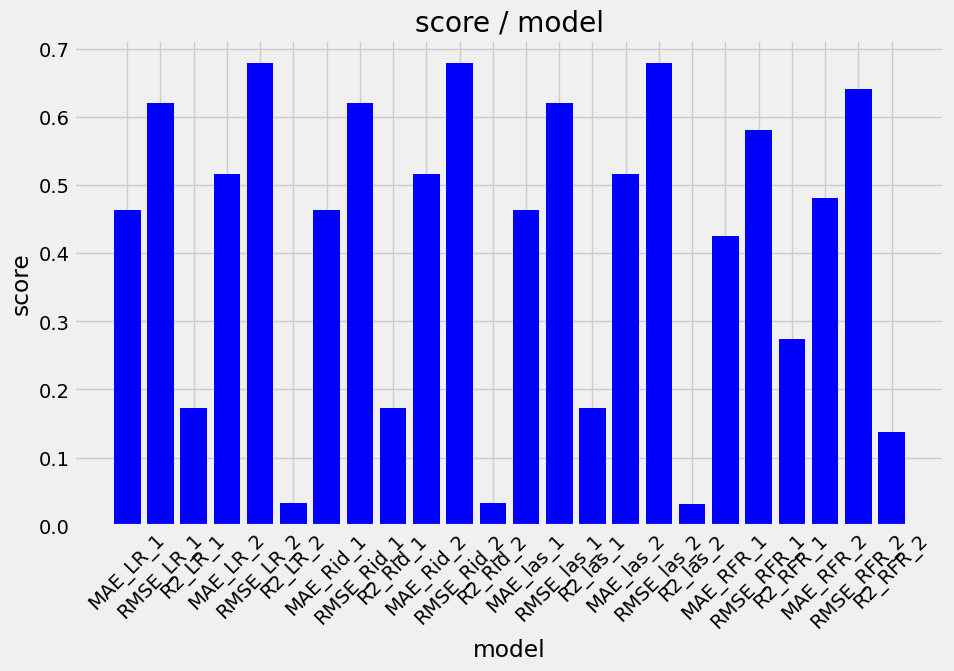

In [52]:
model_list = (MAE_LR_1, RMSE_LR_1, R2_LR_1, MAE_LR_2, RMSE_LR_2, R2_LR_2, MAE_Rid_1, RMSE_Rid_1, R2_Rid_1,
              MAE_Rid_2, RMSE_Rid_2, R2_Rid_2, MAE_las_1, RMSE_las_1, R2_las_1, MAE_las_2, RMSE_las_2, R2_las_2,
              MAE_RFR_1, RMSE_RFR_1, R2_RFR_1, MAE_RFR_2, RMSE_RFR_2, R2_RFR_2)
# model_list_np = np.array(model_list)
model_list_name = ('MAE_LR_1', 'RMSE_LR_1', 'R2_LR_1', 'MAE_LR_2', 'RMSE_LR_2', 'R2_LR_2', 'MAE_Rid_1', 'RMSE_Rid_1', 'R2_Rid_1',
              'MAE_Rid_2', 'RMSE_Rid_2', 'R2_Rid_2', 'MAE_las_1', 'RMSE_las_1', 'R2_las_1', 'MAE_las_2', 'RMSE_las_2', 'R2_las_2',
                 'MAE_RFR_1', 'RMSE_RFR_1', 'R2_RFR_1', 'MAE_RFR_2', 'RMSE_RFR_2', 'R2_RFR_2')
plt.figure(figsize=(10,6))
plt.bar(model_list_name, model_list, color='b')
plt.title('score / model')
plt.ylabel('score')
plt.xlabel('model')
plt.xticks(rotation=45)
plt.show()

Here I decide to work on RMSE, because the visualization is complicated.

RMSE measures the average deviation of the predicted values from the actual values. 

It's calculated by:

Taking the difference between the predicted and actual values.

Squaring each difference.

Taking the mean of those squared differences.

Finally, taking the square root of that mean.

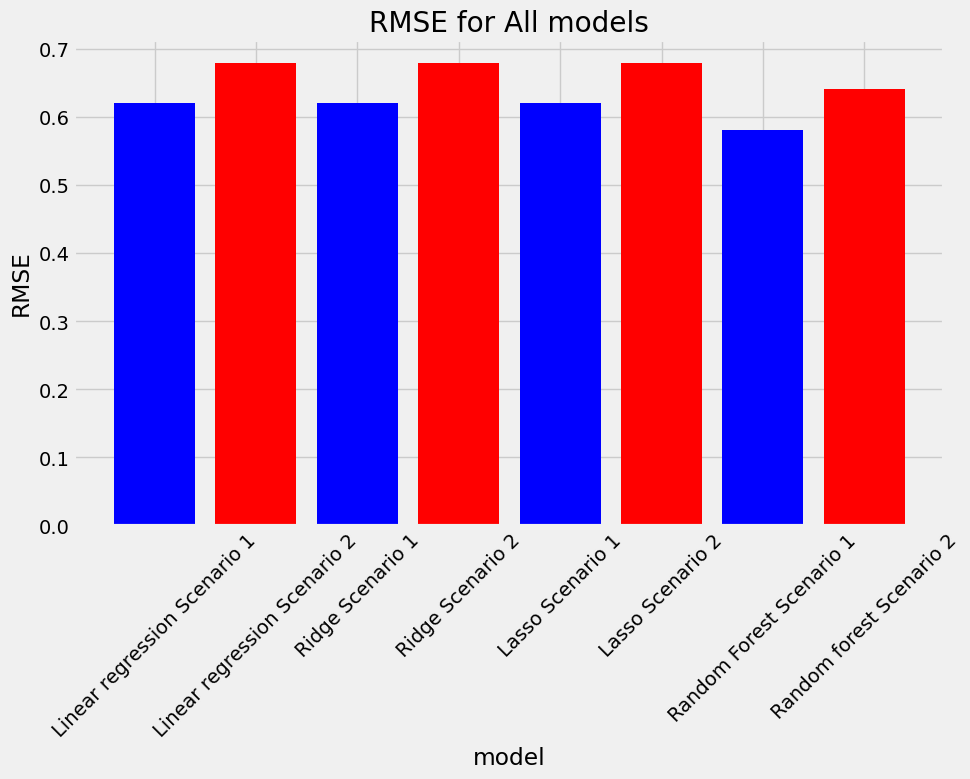

In [53]:
model_list = (RMSE_LR_1, RMSE_LR_2, RMSE_Rid_1, RMSE_Rid_2, RMSE_las_1, RMSE_las_2, RMSE_RFR_1, RMSE_RFR_2)
# model_list_np = np.array(model_list)
model_list_name = ('Linear regression Scenario 1', 'Linear regression Scenario 2', 'Ridge Scenario 1', 'Ridge Scenario 2', 
                   'Lasso Scenario 1', 'Lasso Scenario 2', 'Random Forest Scenario 1', 'Random forest Scenario 2')
colors = ['b', 'r']  # Blue for scenario 1, red for scenario 2
plt.figure(figsize=(10,6))
plt.bar(model_list_name, model_list, color=[colors[i%2] for i in range(len(model_list))])
plt.title('RMSE for All models')
plt.ylabel('RMSE')
plt.xlabel('model')
plt.xticks(rotation=45)
plt.show()

A lower RMSE indicates better accuracy of the predictive model. As we can see here scenario 2 has higher RMSE. The lowest RMSE is Random Forest in scenario 1. It means the best model is Random Forest with all feature that I select first.

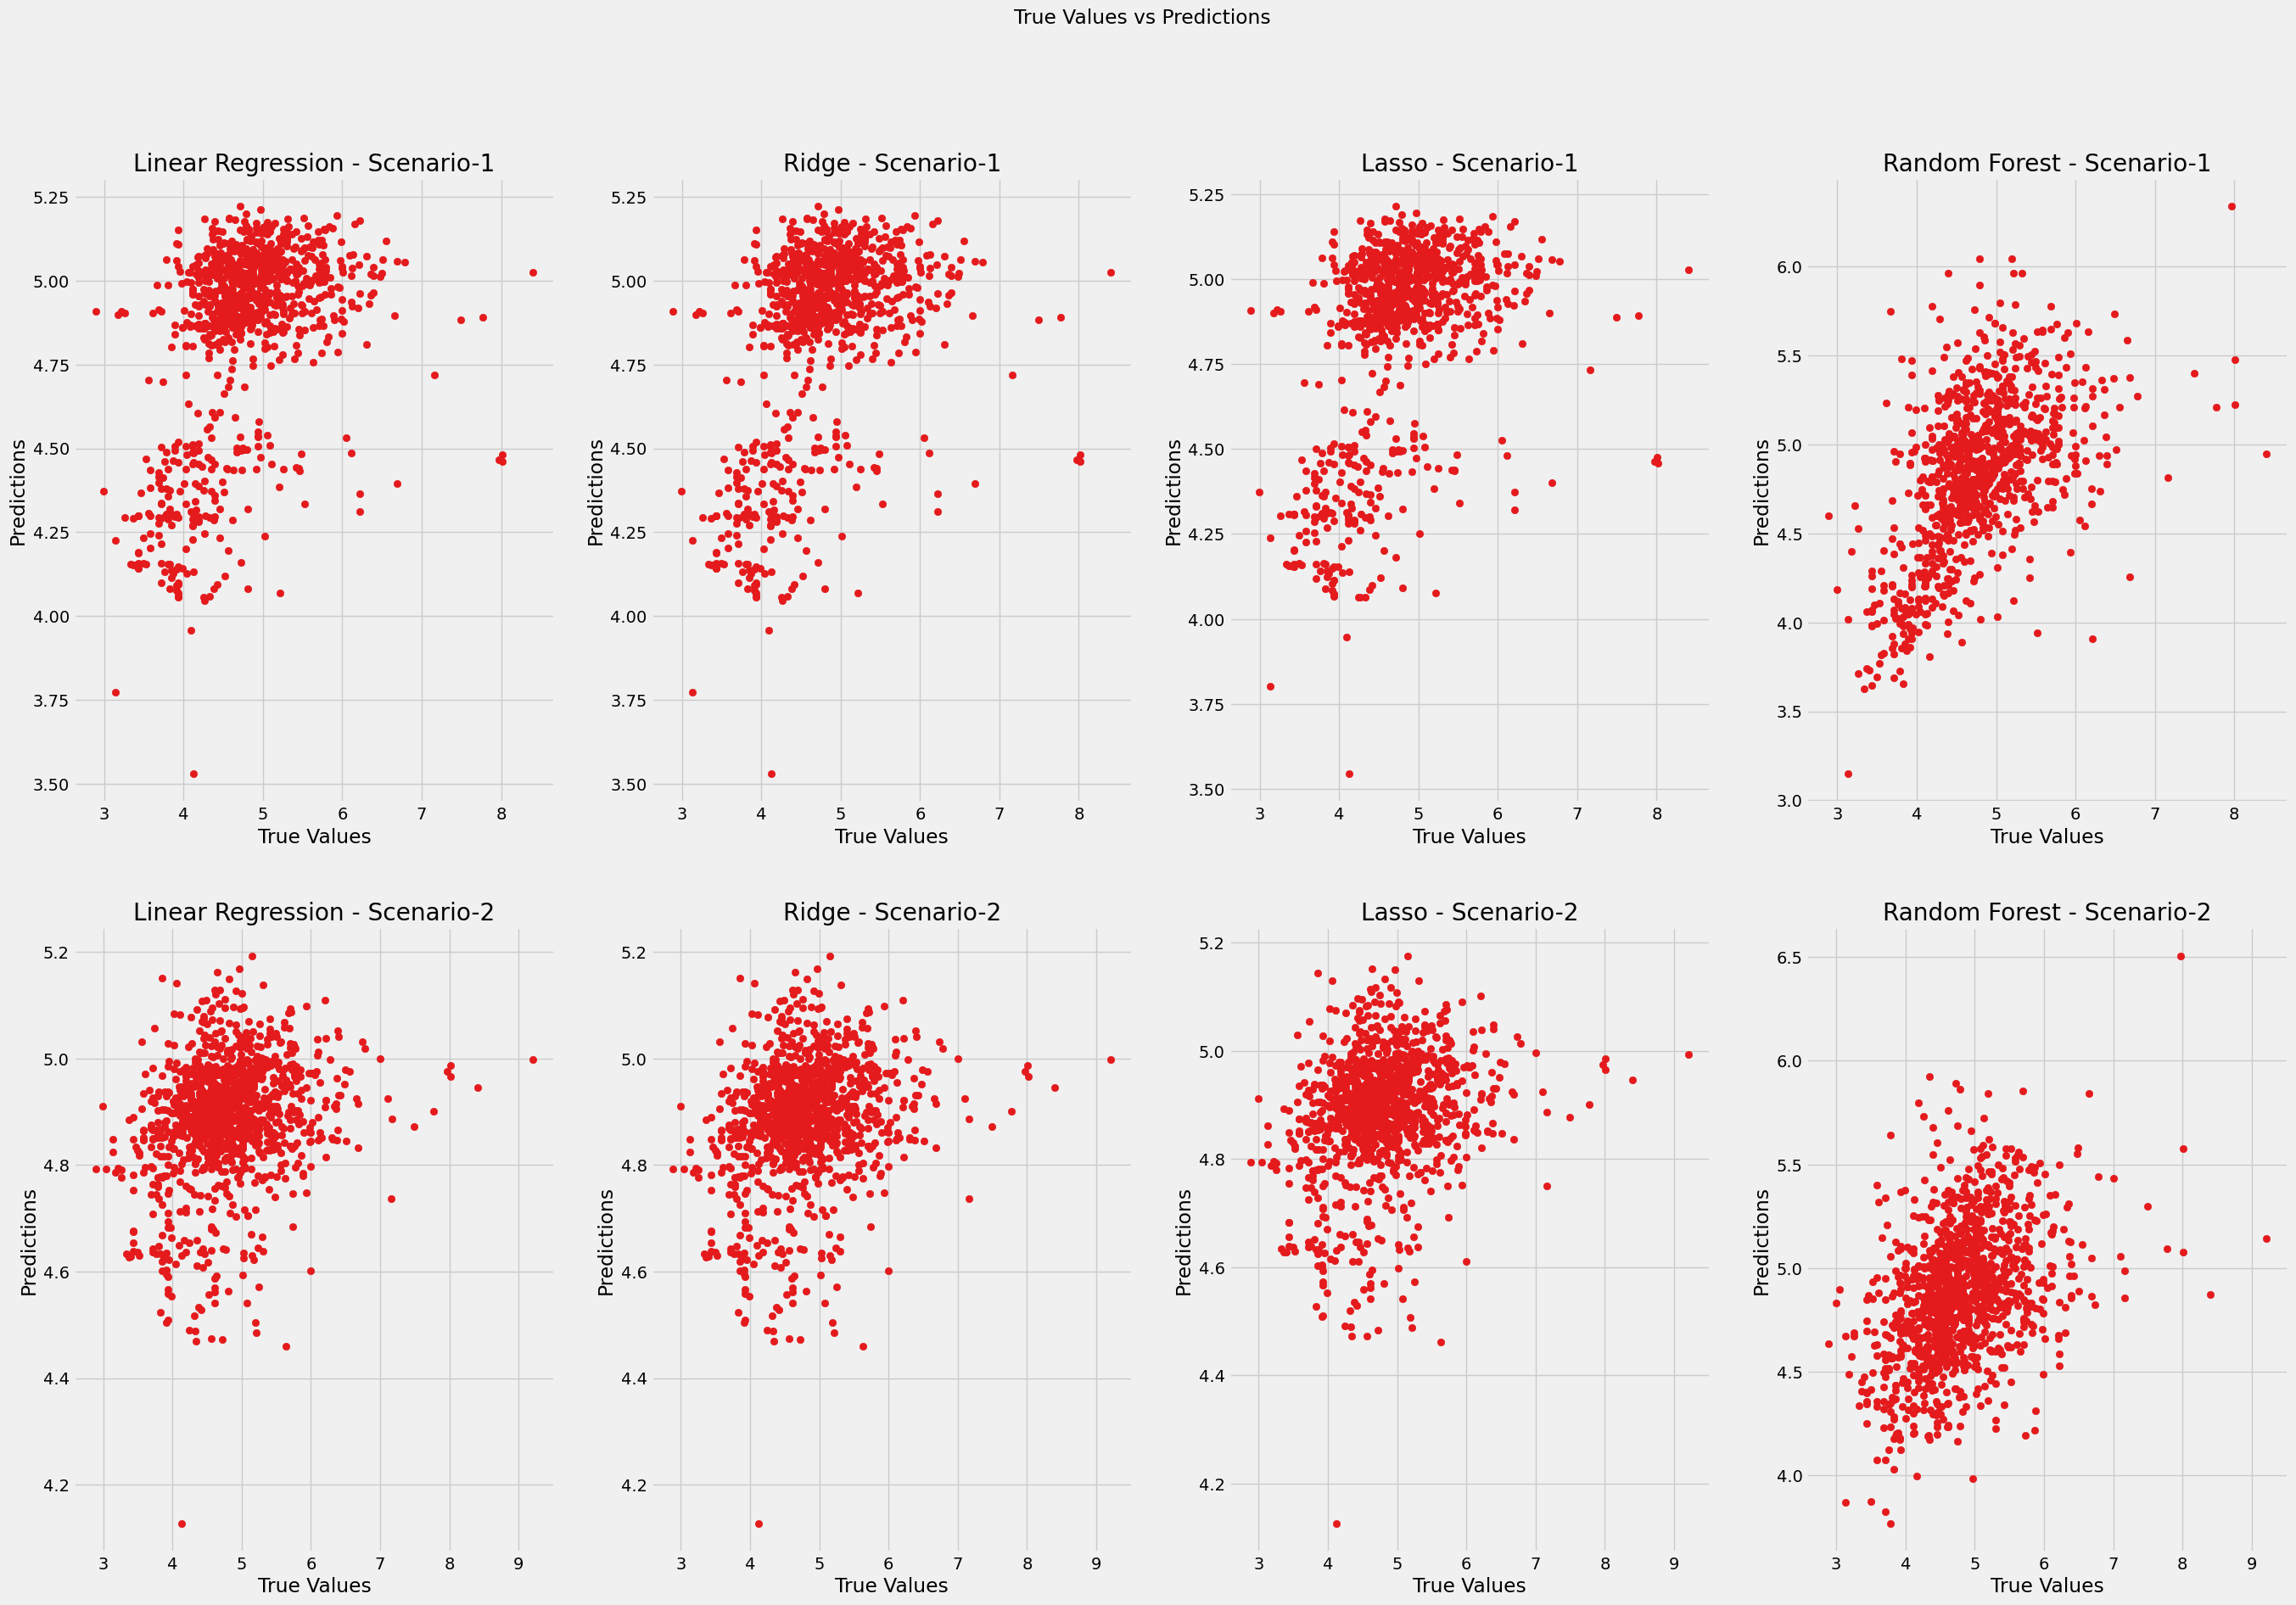

In [54]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(30, 20))
fig.suptitle('True Values vs Predictions')

ax1.scatter(y_test, lr_pred)
ax1.set_title('Linear Regression - Scenario-1')

ax2.scatter(y_test, pred_ridge)
ax2.set_title('Ridge - Scenario-1')

ax3.scatter(y_test, pred_Lasso)
ax3.set_title('Lasso - Scenario-1')

ax4.scatter(y_test, pred_RFR)
ax4.set_title('Random Forest - Scenario-1')

ax5.scatter(y_test_x, lr_pred_x)
ax5.set_title('Linear Regression - Scenario-2')

ax6.scatter(y_test_x, pred_ridge_x)
ax6.set_title('Ridge - Scenario-2')

ax7.scatter(y_test_x, pred_Lasso_x)
ax7.set_title('Lasso - Scenario-2')

ax8.scatter(y_test_x, pred_RFR_x)
ax8.set_title('Random Forest - Scenario-2')

for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')

We can notice to these tips below:

Model Accuracy: You can visually assess how well the model predictions match the actual values. A tight cluster of points along a diagonal line (with slope 1) indicates a strong correlation between predicted and actual values, suggesting good model accuracy.

Outliers: Outliers, or points far from the diagonal line, might indicate areas where the model performs poorly or where there are extreme values in the data.

Model Fit: The overall shape of the scatter plot can provide insights into the overall fit of the model. A non-linear relationship between actual and predicted values might suggest that the model is not capturing the underlying patterns in the data.

As we can see with scenario 1 has tight cluster, less outliers. And this model has the linear relationship between actual and predicted values.

## 5.11 Variance Score<a id='5.11_Variance_Score'></a>

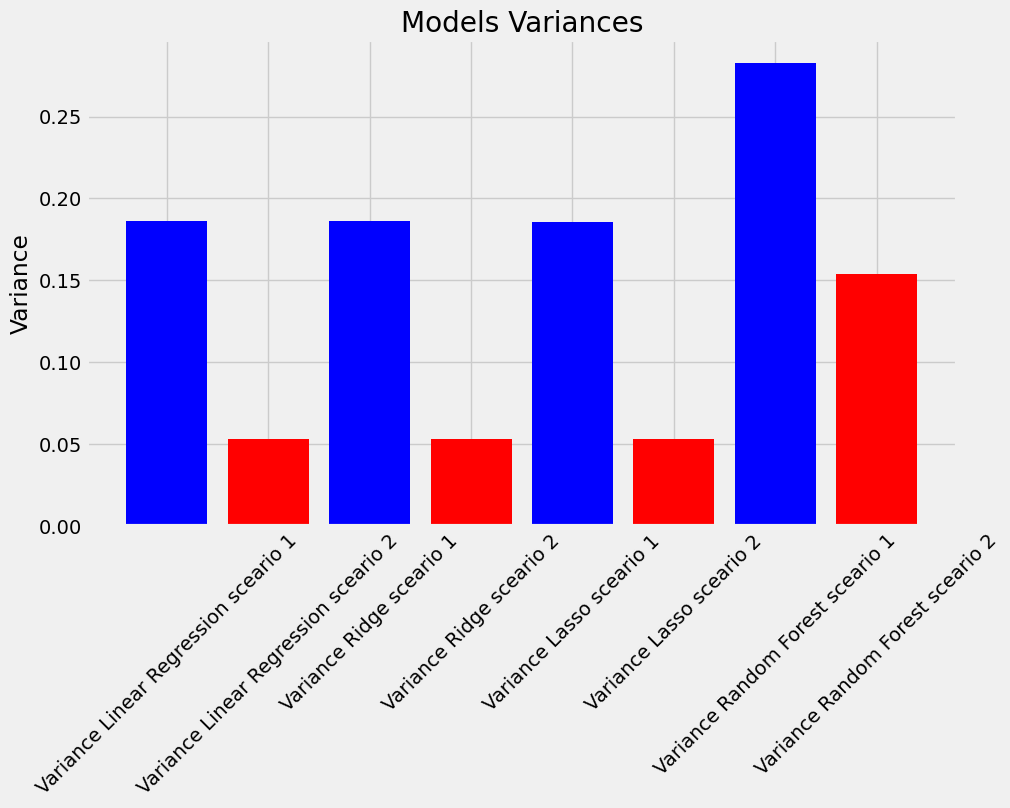

In [55]:
var_lr_1 = explained_variance_score(y_test, lr_pred)
var_lr_2 = explained_variance_score(y_test_x, lr_pred_x)
var_rid_1 = explained_variance_score(y_test, pred_ridge)
var_rid_2 = explained_variance_score(y_test_x, pred_ridge_x)
var_los_1 = explained_variance_score(y_test, pred_Lasso)
var_los_2 = explained_variance_score(y_test_x, pred_Lasso_x)
var_RFR_1 = explained_variance_score(y_test, pred_RFR)
var_RFR_2 = explained_variance_score(y_test_x, pred_RFR_x)
var_model = [var_lr_1, var_lr_2, var_rid_1, var_rid_2, var_los_1, var_los_2, var_RFR_1, var_RFR_2]
var_model_name = ['Variance Linear Regression sceario 1', 'Variance Linear Regression sceario 2', 'Variance Ridge sceario 1', 
                  'Variance Ridge sceario 2', 'Variance Lasso sceario 1', 'Variance Lasso sceario 2', 
                  'Variance Random Forest sceario 1', 'Variance Random Forest sceario 2']
colors = ['b', 'r']  # Blue for scenario 1, red for scenario 2
plt.figure(figsize=(10,6))
plt.bar(var_model_name, var_model,  color=[colors[i%2] for i in range(len(model_list))])
plt.title('Models Variances')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()

Variance measures how much the model's predictions deviate from the mean of the actual values. A higher variance score indicates that the model can explain more of the variance in the data, meaning it captures the underlying patterns better.
As we can see Variance Random Forest for scenario 1 has the highest Variance.

## 5.12 Create The Best Model <a id='5.11_Variance_Score'></a>

I try to use the random_forest_reg function that I defined before. It use the GridSearchCV that gives us the best parameter for our random forest model that we defined. Here we have five parameters below:

'n_estimators': [10, 50, 100],

'max_depth': [None, 10, 20, 30],

'min_samples_split': [2, 5, 10],

'min_samples_leaf': [1, 2, 4],

'bootstrap': [True, False]

After that it give us its score of the best model.

In [56]:
random_forest_reg(X_train, y_train, cv=5)

{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
-0.3499235236387013


The best parameters:

'bootstrap': True,

'max_depth': 20,

'min_samples_leaf': 4,

'min_samples_split': 5,

'n_estimators': 100

We 

In [59]:
# Define the best parameters
best_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'bootstrap': True
}

# Instantiate the Random Forest model with the best parameters
best_rf_model = RandomForestRegressor(**best_params)

# Train the model
best_rf_model.fit(X_train, y_train)

# Make predictions
pred_rf = best_rf_model.predict(X_test)

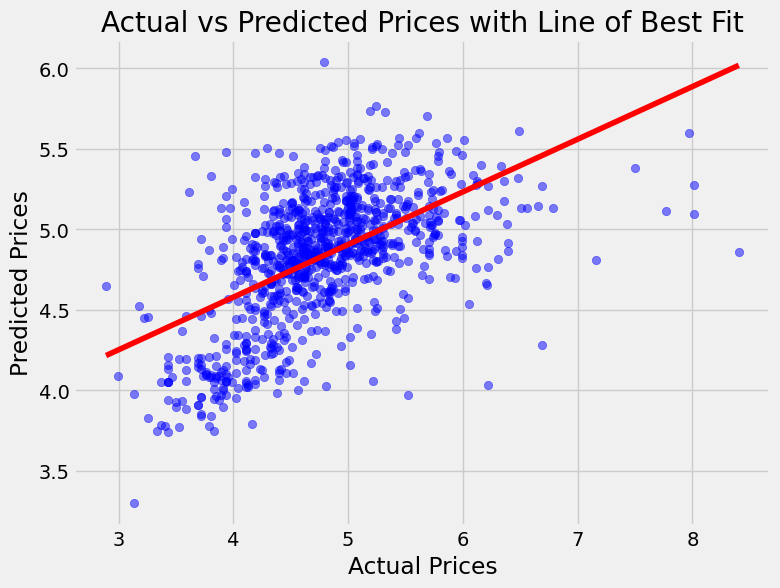

In [61]:
# Add a line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_rf, color='blue', alpha=0.5)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, pred_rf, 1))(np.unique(y_test)), color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices with Line of Best Fit')
plt.show()

## 5.12 Save The Best Model

In [62]:
import pickle

# Save the model to a file
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)

## 5.13 Conclusions:

- Scenario 1 is better, so, we need to keep all features.

- Random forest is the best model in scenario 1 and 2.

- Finally we can find the best model with the best parameters to predict the nightly airbnb price.

## 5.14 Summary:

- Four models were created here:

Linear Regression, Ridge, Lasso, and Random Forest.

- Two scenarios were existed:

1. Scenario with all deatures

2. Scenario without two features room type and neighborhood cleansed that were less important.

- Totally Random Forest with scenario 1 has the highest variance and lowest RMSE that it shows it was the best model for prediction of log price of denver airbnb.

- I use GridSearchCv to find the best paramaters for Random Forest scenario 1. The results is shown below:

The best parameters:

'bootstrap': True,

'max_depth': 20,

'min_samples_leaf': 4,

'min_samples_split': 5,

'n_estimators': 100

- I used these parameters to create the best model for my data, and it was saved.
    